### Prepare spatial training data

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
import imageio
import xarray
import scipy
import inspect # from package inspect-it
import sys
import torch
import scipy
import scipy.ndimage
import torch.nn as nn
import torch.nn.functional as F
import tracemalloc
import skimage
import random
from torch.nn.functional import softmax, cosine_similarity
from torch.nn import LeakyReLU
from scipy import stats
from seaborn import heatmap, clustermap
from scipy.spatial import KDTree
from skimage.measure import regionprops 
from PIL import Image
from skimage import data, color
from skimage.transform import rescale, resize, resize_local_mean
Image.MAX_IMAGE_PIXELS = None # remove pixel size limit

To install a pip package in the current Jupyter kernel:

In [2]:
#import sys
#!{sys.executable} -m pip install -U wandb

### Define Class and Funtions 

In [2]:
class FullNet(nn.Module):
    def __init__(self, n_genes, latent_variable_dim, e=64, size_pooling1=4, size_pooling2=2,
                 batch_size=3):
        """
        Model based on nn.Module, which combines : a CNN to produce a feature vector from spatial expression data, 
        which is then combined with x_gc, the gene expression confidently attributed to a cell c. Both vectors are
        then concatenated and passed in a fully connected NN to compute pi_kc, the cell-type probabilities. These
        probability are then converted to a quasi-categorical variable with a gumbel softmax. Using a scRNA-seq as
        a reference, we then compute x_hat with poisson sampling. 
        Args:
            n_genes (int): The number of genes in our spatial expression data. Helps to define the number of channels in CNN
            latent_variable_dim (int): correspond to the number of cell-types we consider, and to the dimension of pi_kc
            tau (float): temperature parameter for gumbel softmax quasi discrete sampling
        """
        super().__init__()
        self.n_genes = int(n_genes)
        self.latent_variable_dim = int(latent_variable_dim)
        self.batch_size = batch_size
        ### LOCAL NEIGHBORHOOD VARIABLES ### 
        self.n_channels_local = int(n_genes + 2) # we add two channels for img+seg
        self.len_vec_cnn_local = int(((e*2)*(e*2)*self.n_channels_local)/((size_pooling1**2)*(size_pooling2**2)*(size_pooling2**2)))
        self.conv1 = nn.Conv2d(self.n_channels_local, self.n_channels_local, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(self.n_channels_local, self.n_channels_local, kernel_size=3, stride=1, padding=1)
        self.bnorm1 = nn.BatchNorm2d(int(self.n_channels_local))
        self.bnorm2 = nn.BatchNorm2d(int(self.n_channels_local))
        self.leakyrelu1 = nn.LeakyReLU(int(self.n_channels_local))
        self.leakyrelu2 = nn.LeakyReLU(int(self.n_channels_local))
        self.conv3 = nn.Conv2d(self.n_channels_local, self.n_channels_local, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(self.n_channels_local, self.n_channels_local, kernel_size=3, stride=1, padding=1)
        self.bnorm3 = nn.BatchNorm2d(int(self.n_channels_local))
        self.leakyrelu3 = nn.LeakyReLU(int(self.n_channels_local))
        self.bnorm4 = nn.BatchNorm2d(int(self.n_channels_local))
        self.leakyrelu4 = nn.LeakyReLU(int(self.n_channels_local))
        self.conv5 = nn.Conv2d(self.n_channels_local, self.n_channels_local, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(self.n_channels_local, self.n_channels_local, kernel_size=3, stride=1, padding=1)
        self.bnorm5 = nn.BatchNorm2d(int(self.n_channels_local))
        self.leakyrelu5 = nn.LeakyReLU(int(self.n_channels_local))
        self.bnorm6 = nn.BatchNorm2d(int(self.n_channels_local))
        self.leakyrelu6 = nn.LeakyReLU(int(self.n_channels_local))
        self.pool1 = nn.MaxPool2d(size_pooling1, size_pooling1) #   self.pool = nn.MaxPool2d(4,4)
        self.pool2 = nn.MaxPool2d(size_pooling2, size_pooling2)
        self.pool3 = nn.MaxPool2d(size_pooling2, size_pooling2)
        self.fc1 = nn.Linear(self.len_vec_cnn_local, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, self.latent_variable_dim)
        ### GLOBAL NEIGHBORHOOD VARIABLES ### 
        self.n_channels_global = int(n_genes + 3) # we add 3 channels for img+seg+seg_coi (cell of interest)
        self.len_vec_cnn_global = int(((e*2)*(e*2)*self.n_channels_global)/((size_pooling1**2)*(size_pooling2**2)*(size_pooling2**2)))
        self.conv1_g = nn.Conv2d(self.n_channels_global, self.n_channels_global, kernel_size=3, stride=1, padding=1)
        self.conv2_g = nn.Conv2d(self.n_channels_global, self.n_channels_global, kernel_size=3, stride=1, padding=1)
        self.bnorm1_g = nn.BatchNorm2d(int(self.n_channels_global))
        self.bnorm2_g = nn.BatchNorm2d(int(self.n_channels_global))
        self.leakyrelu1_g = nn.LeakyReLU(int(self.n_channels_global))
        self.leakyrelu2_g = nn.LeakyReLU(int(self.n_channels_global))
        self.conv3_g = nn.Conv2d(self.n_channels_global, self.n_channels_global, kernel_size=3, stride=1, padding=1)
        self.conv4_g = nn.Conv2d(self.n_channels_global, self.n_channels_global, kernel_size=3, stride=1, padding=1)
        self.bnorm3_g = nn.BatchNorm2d(int(self.n_channels_global))
        self.leakyrelu3_g = nn.LeakyReLU(int(self.n_channels_global))
        self.bnorm4_g = nn.BatchNorm2d(int(self.n_channels_global))
        self.leakyrelu4_g = nn.LeakyReLU(int(self.n_channels_global))
        self.conv5_g = nn.Conv2d(self.n_channels_global, self.n_channels_global, kernel_size=3, stride=1, padding=1)
        self.conv6_g = nn.Conv2d(self.n_channels_global, self.n_channels_global, kernel_size=3, stride=1, padding=1)
        self.bnorm5_g = nn.BatchNorm2d(int(self.n_channels_global))
        self.leakyrelu5_g = nn.LeakyReLU(int(self.n_channels_global))
        self.bnorm6_g = nn.BatchNorm2d(int(self.n_channels_global))
        self.leakyrelu6_g = nn.LeakyReLU(int(self.n_channels_global))
        self.pool1_g = nn.MaxPool2d(size_pooling1, size_pooling1) #   self.pool = nn.MaxPool2d(4,4)
        self.pool2_g = nn.MaxPool2d(size_pooling2, size_pooling2)
        self.pool3_g = nn.MaxPool2d(size_pooling2, size_pooling2)
        self.fc1_g = nn.Linear(self.len_vec_cnn_global, 1000)
        self.fc2_g = nn.Linear(1000, 100)
        self.fc3_g = nn.Linear(100, self.latent_variable_dim)
        
    def f_lambda_local(self, input_cnn):
        """
        f_lambda is a function that use two rounds of Convolution/ReLu/MaxPool on a 3D matrix containing dapi 
        image and segmentation, coupled with spatial gene expression. 
        Args:
            input_CNN (3D tensor): contains dapi info and binned spatial expresion
        Returns:
            (1D tensor): a one-dimensional tensor summarizing the image and expression data after CNN 
        """
        residual = input_cnn.clone()
        x = self.leakyrelu1(self.bnorm1(self.conv1(input_cnn)))
        x = self.leakyrelu2(self.bnorm2(self.conv2(x)))
        x = torch.add(x, residual)
        x = self.pool1(x)
        residual2 = x.clone()
        x = self.leakyrelu3(self.bnorm3(self.conv3(x)))
        x = self.leakyrelu4(self.bnorm4(self.conv4(x)))
        x = torch.add(x, residual2)
        x = self.pool2(x)
        #residual3 = x.clone()
        #x = self.leakyrelu5(self.bnorm5(self.conv5(x)))
        #x = self.leakyrelu6(self.bnorm6(self.conv6(x)))
        #x = torch.add(x, residual3)
        x = self.pool3(x)
        x = x.reshape(self.batch_size, self.len_vec_cnn_local)
        return(x)

    def f_gamma_local(self, output_cnn):
        """
        f_gamma takes as input the output of f_lambda, that is to say the 1D tensor output from a CNN, and
        concatenate it with x_gc, another 1D tensor containing the spatial gene expression confidently attributed
        to cell c by proximity. 
        Args:
            output_CNN (1D tensor): a one-dimensional tensor summarizing the image and expression data after CNN 
            x_gc (1D tensor): a one-dimensional tensor containing spatial gene expression counts attributed to a cell
        Returns:
            (1D tensor): a one-dimensional tensor of length K (number of cell-types), corresponding to pi_kc
        """
        # use only CNN input 
        x = F.relu(self.fc1(output_cnn))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def f_lambda_global(self, input_cnn):
        """
        f_lambda is a function that use two rounds of Convolution/ReLu/MaxPool on a 3D matrix containing dapi 
        image and segmentation, coupled with spatial gene expression. 
        Args:
            input_CNN (3D tensor): contains dapi info and binned spatial expresion
        Returns:
            (1D tensor): a one-dimensional tensor summarizing the image and expression data after CNN 
        """
        residual = input_cnn.clone()
        x = self.leakyrelu1_g(self.bnorm1_g(self.conv1_g(input_cnn)))
        x = self.leakyrelu2_g(self.bnorm2_g(self.conv2_g(x)))
        x = torch.add(x, residual)
        x = self.pool1_g(x)
        residual2 = x.clone()
        x = self.leakyrelu3_g(self.bnorm3_g(self.conv3_g(x)))
        x = self.leakyrelu4_g(self.bnorm4_g(self.conv4_g(x)))
        x = torch.add(x, residual2)
        x = self.pool2_g(x)
        #residual3 = x.clone()
        #x = self.leakyrelu5_g(self.bnorm5_g(self.conv5_g(x)))
        #x = self.leakyrelu6_g(self.bnorm6_g(self.conv6_g(x)))
        #x = torch.add(x, residual3)
        x = self.pool3_g(x)
        x = x.reshape(self.batch_size, self.len_vec_cnn_global)
        return(x)

    def f_gamma_global(self, output_cnn):
        """
        f_gamma takes as input the output of f_lambda, that is to say the 1D tensor output from a CNN, and
        concatenate it with x_gc, another 1D tensor containing the spatial gene expression confidently attributed
        to cell c by proximity. 
        Args:
            output_CNN (1D tensor): a one-dimensional tensor summarizing the image and expression data after CNN 
            x_gc (1D tensor): a one-dimensional tensor containing spatial gene expression counts attributed to a cell
        Returns:
            (1D tensor): a one-dimensional tensor of length K (number of cell-types), corresponding to pi_kc
        """
        # use only CNN input 
        x = F.relu(self.fc1_g(output_cnn))
        x = F.relu(self.fc2_g(x))
        x = self.fc3_g(x)
        return x
        
    def categorical(self, pi_kc, tau):
        """
        Uses a Gumbel softmax to produce a quasi discrete sampling from pi_kc probabilities 
        Args:
            pi_kc (1D tensor): cell type probability distribution
            tau (float): temperature parameter used by gumbel softmax method
        Returns:
            z_kc (1D tensor): quasi one-hot-encoded cell type distribution
        """
        return F.gumbel_softmax(pi_kc, tau=tau, dim=1).double() #
        
    def project_to_centroids(self, z_kc, S):
        """
        Projects a given (quasi) one-hot-encoded cell type distribution into the corresponding cluster centroid
        Args:
            z_kc (1D tensor): quasi one-hot-encoded cell type distribution
            S (2D tensor): Average expression, (genes x cell-types), from a scRNA-seq data in the same context
        Returns:
            mu_k: average expression of cell-type k
        """
        mu_k = torch.matmul(S, z_kc.T)
        return(mu_k)

    def sample_poisson(self, mu_k):
        """
        return a poisson sampling - thus discrete counts attributed to each gene, mimicking x_gc, 
        and using values in mu_k as factor lambda for poisson distribution 
        Args:
            mu_k (1D tensor): Poisson parameter given by the network
        Returns:
            x_hat (1D tensor): the predicted gene expression
        """
        return torch.poisson(mu_k)[:,0]

    def forward(self, input_cnn_local, input_cnn_global, S, tau, mode='full'):
        """
        Forward pass of the network
        Args:
            input_CNN (3D tensor): contains dapi info and binned spatial expresion
            x_gc (1D tensor): a one-dimensional tensor containing spatial gene expression counts
            S (2D tensor): average expression per cell-type derived from a scRNA-seq reference dataset
        Returns:
            xhat (1D tensor): the predicted gene expression
        """
        output_cnn_local = self.f_lambda_local(input_cnn_local)
        pi_kc_local = self.f_gamma_local(output_cnn_local)
        output_cnn_global = self.f_lambda_global(input_cnn_global)
        pi_kc_global = self.f_gamma_global(output_cnn_global)
        z_kc = self.categorical(pi_kc_local + pi_kc_global, tau)
        mu_k = self.project_to_centroids(z_kc, S)
        #x_hat = self.sample_poisson(mu_k)
        return mu_k, pi_kc_local, pi_kc_global, z_kc

In [9]:
def logger(comment):
    """Function to print Class::Name - Comments from any classes

    Args:
        comment (str): comment to add to the logger
    """
    class_fun_str = inspect.stack()[1][0].f_locals["self"].__class__.__name__ + "::" + \
                    inspect.stack()[1].function + "()"
    print("{:<40} - {:<50}".format(class_fun_str, comment))

def drawProgressBar(percent, barLen = 100):
    # percent float from 0 to 1. 
    sys.stdout.write("\r")
    sys.stdout.write("[{:<{}}] {:.0f}%".format("=" * int(barLen * percent), barLen, percent * 100))
    sys.stdout.flush()

class Cell(object):
    def __init__(self, x, loc, label, e=None, A=None, seg=None, mask=None, img=None, pi=None, z=None):
        """This class contain a Cell and all data related to a single-cell c
        
        Args:
            x (torch.tensor, 1D): the spatial gene expression, from dots confidently attributed to cell c
            A (xarray, 3D): 3D spatial expression containing coordinate of gene counts in local neighborhood
            loc (pd.Series, 1D): contain x,y location of cell c centroid, accessible via .loc.x or .loc.y
            seg (np.array, 2D): segmentation centered on cell c containing neighbor cells in local neighborhood
            mask (np.array, 2D): binary mask from segmentated object in local neighborhood
            img (np.array, 2D): image centered on cell c containing neighbor cells in local neighborhood
            label (int): label of cell c
            e (int): size of local neighborhood window, centroids will be enlarged by +/- e 
            pi (torch 1D tensor): probability to be affiliated to each K cell type
            z (torch 1D tensor): assignment of cell type based on pi_c
        """
        self.x = torch.tensor(x)
        self.A = A
        self.loc = loc
        self.label = label
        self.seg = seg
        self.mask = mask
        self.img = img
        self.pi = pi
        self.z = z
        self.x_start = None ; self.x_end = None
        self.y_start = None ; self.y_end = None
        self.on_boarder = False
        self.input_CNN = None
        self.testing = None

    def initialize(self, e, x_width, y_width):
        # record coordinates of local neighborhood
        self.x_start = int(self.loc.x - e) ; self.x_end = int(self.loc.x + e)
        self.y_start = int(self.loc.y - e) ; self.y_end = int(self.loc.y + e)
        # Check if cell is on boarder
        if self.x_start < 0 or self.y_start < 0 or self.x_end > x_width or self.y_end > y_width:
            self.on_boarder = True
        
class CellContainer(object):
    def __init__(self, img, seg, D, e, S, A=None, X=None, loc=None, cell_labels=None, gene_names=None, 
                 celltype_labels=None, min_count=5, ignore_cells_with_0transript = True):
        """CellContainer class contains all segmented cells from an image, and their associated spatial gene expression
        
        Args:
            img (np.array, 2D): dapi staining raw image, size (width_X, width_Y)
            seg (np.array, 2D): nuclei segmentation based on dapi staining
            D (pd.DataFrame, 3 columns): Gene dots information, columns are (gene_name, x_coord, y_coord).
            e (int): size of enlargement around cell centroids for making crops used by CNN.
            S (pd.DataFrame): average expression per cell-type derived from a scRNA-seq reference dataset
            A (xarray, 3D): contains the dot corresponding the spatial gene counts.xarray of size (G, width_X, width_Y), G being the number of genes, and (width_X,width_Y) the size of the full image. Calculated on the fly from D.
            X (np.array, 2D): contains the gene counts confidently assigned to each cell c segmented in the spatial data. Calculated on the fly from seg, C, and D.
            loc (pandas, 3 columns): cell centroid information, columns are (cell_label, x_coord, y_coord)
            cell_labels (pd.Series, 1D): labels of cells in X, based on labels in segmentation matrix. Calculated on the fly from seg.
            gene_names (pd.Series, 1D): labels of genes in matrix A, X, and M. Calculated on the fly from unique gene names in D.
            celltype_labels (pd.Series, 1D): labels of cell-types in M. 
            ignore_cells_with_0transript (bool): [default: True] defines if cells that get 0 RNA transcript should be ignored
        """
        self.img = img
        self.seg = seg
        self.D = D
        self.e = e
        self.S = S
        self.S_n = torch.tensor(np.array(S / S.sum()))
        self.A = A 
        self.X = X
        self.K=S.shape[1]
        self.loc = None
        self.D_closest_cell = None
        self.cell_labels = pd.Series(np.unique(self.seg)[1:]) # Build variable with unique Cell IDs
        self.ignore_cells_with_0transript = ignore_cells_with_0transript
        self.cells = []
        self.cells_training = [] # list containing all Cell in image
        self.cells_testing = []
        self.x_width = self.seg.shape[0]
        self.y_width = self.seg.shape[1]
        self.n_cells_considered = 0
        self.train_test_list = []
        self.min_count = min_count
        self.all_min_loss = None#np.ones(n_cells)
        self.all_k = None#np.zeros(n_cells)
        # set-up function 
        self.define_gene_overlap()

    def define_gene_overlap(self):
        """Function to find the list of gene names that overlaps between input data matrices"""
        self.gene_names = pd.Series(sorted(set(self.D.name).intersection(set(self.S.index))))
        self.D = self.D.iloc[np.array(self.D.name.isin(self.gene_names))]
        self.D.index = range(self.D.shape[0]) # reindex
        self.S = self.S.iloc[np.array(self.S.index.isin(self.gene_names))]
        self.S.sort_index(inplace=True)
        if len(self.gene_names) > 0:
            logger(f"Found {len(self.gene_names)} overlapping gene names")
        else:
            raise ValueError('No overlap between gene names in D and S')
        
    def get_cell_centroids(self):
        """Function to find cell centroids based on cell segmentation"""
        logger(f'Computing cell centroids based on segmentation file')
        regionprops_out = regionprops(label_image=self.seg)
        labels = [] ; coord_x = [] ; coord_y = []
        for this_seg in regionprops_out:
            labels.append(this_seg.label)
            coord_x.append(this_seg.centroid[0]) 
            coord_y.append(this_seg.centroid[1]) 
        self.loc = pd.DataFrame([labels, coord_x, coord_y], index=['cell_label', 'x', 'y']).T
        
    def find_closest_cell(self, max_shift=50):
        """Given (cell_x, cell_y) cell centroid coordinates, returns the closest cell in a radius of max_shift"""
        logger(f'Attributing gene dots to closest cells')
        dot_positions = np.array(self.D[['x','y']])
        cell_positions = np.array(self.loc[['x','y']])
        # we use KDTree from scipy.spatial
        tree = KDTree(cell_positions)
        # query the k-d tree for the closest points to set1
        distances, indices = tree.query(dot_positions)
        # get the actual closest points
        closest_cells = self.loc.index[indices]
        closest_cells = np.array(closest_cells)
        closest_cells[distances > max_shift] = 0
        self.D_closest_cell = pd.DataFrame([closest_cells, dot_positions[:,0], dot_positions[:,1]], 
                                      index=['closest_cell', 'x', 'y']).T
        
    def build_X_matrix(self, max_shift=30):
        """Based on segmentation and x,y coordinates of a cell, the closest cell is returned
            If no cell is found in a distance of max_shift around the gene dot, 0 will be
            returns meaning no cell attributed"""
        logger("""Build matrix X based on dot attribution""")
        value = np.ones(self.D_closest_cell.shape[0])
        value[np.array(self.D_closest_cell.closest_cell == 0)] = 0
        self.D_closest_cell.insert(3, 'value', value=value)
        self.D_closest_cell.insert(4, 'name', self.D.name)
        self.X = self.D_closest_cell.pivot_table(index='closest_cell', columns='name', values='value',
                                         aggfunc= 'sum').fillna(0).astype(int)
        self.X = self.X.T.iloc[self.X.columns.isin(self.S.index)].T
        # If we want to add lines for cells with 0 counts: 
        self.X = self.X.reindex(np.unique(self.seg)[1:]-1).fillna(0.0)
        #if self.min_count > 0:
        self.X = self.X.iloc[np.array(self.X.sum(axis=1) >= self.min_count)]
        logger('Keeping '+str(self.X.shape[0])+' cells with more than '+str(self.min_count)+' RNA counts')
        self.cell_labels = self.X.index
        self.gene_names = self.X.columns

    def build_Cell_objects(self):
        """Build Cell objects based on cell_labels, X, seg, and cell centroids, used as training data for our model."""
        logger("Build Cell objects based on X, A, seg, and cell centroids")
        logger("Iterating over cells:")
        n_cells = len(self.cell_labels)
        criterion = nn.PoissonNLLLoss(log_input=False)
        #n_cells = CellContainer_obj.n_cells_considered
        self.all_min_loss = np.ones(n_cells) ; self.all_k = np.zeros(n_cells)
        for cn, c in enumerate(self.cell_labels):
            Cell_obj = Cell(x=self.X.loc[c], loc=self.loc.loc[c], label=c)
            Cell_obj.initialize(e=self.e, x_width=self.x_width, y_width=self.y_width)
            x_true = Cell_obj.x.clone().detach().double()    
            min_loss = 100.0 ; min_k = 0
            loss_z_k = np.zeros(self.S_n.shape[1])
            for k in range(self.S_n.shape[1]):
                loss_k = criterion(self.S_n[:,k], x_true)
                loss_z_k[k] = loss_k
                if loss_k.item() < min_loss:
                    min_loss = loss_k.item()
                    z_kc = np.zeros(self.S_n.shape[1])
                    z_kc[k] = 1
                    min_k = k
            self.all_min_loss[cn] = min_loss
            self.all_k[cn] = min_k
            Cell_obj.min_loss = min_loss
            Cell_obj.celltype = min_k 
            Cell_obj.celltype_label = self.S.columns[min_k]
            self.cells.append(Cell_obj)
            progress = (cn + 1) / n_cells
            drawProgressBar(progress)
        logger('Subsetting cells to balance cell-type abundances')
        cell_count = np.bincount(np.array(CellContainer_obj.all_k, dtype=int))
        median_cell_count = int(np.median(cell_count))
        selected_cells = []
        for k in range(self.K):
            cell_count_k = cell_count[k]
            cell_args = np.where(self.all_k == k)[0]
            if cell_count_k > max(median_cell_count+1,10):
                cell_args_sub = random.sample(list(cell_args), median_cell_count)
                selected_cells.append(cell_args_sub)
            else:
                selected_cells.append(cell_args)
        cell_subset_args = np.concatenate(np.array(selected_cells, dtype=object))
        new_cells = []
        for idx in cell_subset_args:
            new_cells.append(self.cells[idx])
        self.cells = new_cells
        self.all_min_loss = np.array(self.all_min_loss)[cell_subset_args]
        self.all_k = np.array(self.all_k)[cell_subset_args]
        self.cell_labels = np.array(self.cell_labels)[cell_subset_args]
        logger('Final cell-type counts:')
        print(np.bincount(np.array(self.all_k, dtype=int)))
        logger('Define training/testing set')
        self.train_test_list = np.random.choice([0, 1], size=len(self.cell_labels), p=[.8, .2])
        new_cells = []
        for c, cell in enumerate(self.cells):
            if self.train_test_list[c] == 0:
                self.cells_training.append(cell)
            elif self.train_test_list[c] == 1:
                self.cells_testing.append(cell)
        print(' ')
            
    def create_metadata(self):
        """Create a dataframe with metadata from all cells contained in container."""
        logger("Create a dataframe with metadata from all cells contained in container.")
        all_x, all_y, all_test, all_label, all_counts, all_boarders = [], [], [], [], [], []
        for cell in self.cells_training:
            all_x.append(int(cell.loc.x))
            all_y.append(int(cell.loc.y))
            all_test.append(0)
            all_label.append(int(cell.label))
            all_counts.append(int(torch.sum(cell.x).detach().numpy()))
            all_boarders.append(int(cell.on_boarder))
        self.metadata_training = pd.DataFrame([all_label, all_test, all_x, all_y, all_counts, all_boarders],
                                      index=['cell_name', 'test_set', 'x', 'y', 'total_counts', 'on_boarder']).T
        all_x, all_y, all_test, all_label, all_counts, all_boarders = [], [], [], [], [], []
        for cell in self.cells_testing:
            all_x.append(int(cell.loc.x))
            all_y.append(int(cell.loc.y))
            all_test.append(1)
            all_label.append(int(cell.label))
            all_counts.append(int(torch.sum(cell.x).detach().numpy()))
            all_boarders.append(int(cell.on_boarder))
        self.metadata_testing = pd.DataFrame([all_label, all_test, all_x, all_y, all_counts, all_boarders],
                                      index=['cell_name', 'test_set', 'x', 'y', 'total_counts', 'on_boarder']).T
        
## Define out of class functions
def build_input_CNN(D_, seg_, img_, gene_names_, cell_):
    """Build matrix A based on gene dots in D"""
    #logger("Build matrix A based on gene dots in D")
    #D_.insert(3, 'value_', 1)
    D_['y'] = D_['y'] - cell.y_start
    D_['x'] = D_['x'] - cell.x_start
    all_As = np.zeros((187,e*2,e*2))
    for g, gene in enumerate(gene_names_):
        gene_count_1gene = D_.iloc[np.array(D_.name == gene)]
        for i in range(gene_count_1gene.shape[0]):
            x=gene_count_1gene.iloc[i]['x']
            y=gene_count_1gene.iloc[i]['y']
            all_As[g,x,y] += 1
    mask_ = seg_.copy()
    mask_[mask_ > 0] = 1
    # 3D tensor used as input for CNN 
    input_CNN = torch.tensor(np.concatenate(( mask_.reshape((1,) + mask_.shape), 
                                              img_.reshape((1,) + img_.shape), 
                                              all_As )))
    return(input_CNN)

def normalize_mi_ma(x, mi, ma, clip=False, eps=1e-20, dtype=np.float32):
    if dtype is not None:
        x   = x.astype(dtype,copy=False)
        mi  = dtype(mi) if np.isscalar(mi) else mi.astype(dtype,copy=False)
        ma  = dtype(ma) if np.isscalar(ma) else ma.astype(dtype,copy=False)
        eps = dtype(eps)
    try:
        import numexpr
        x = numexpr.evaluate("(x - mi) / ( ma - mi + eps )")
    except ImportError:
        x =                   (x - mi) / ( ma - mi + eps )
    if clip:
        x = np.clip(x,0,1)
    return x

def normalize_img(x, pmin=3, pmax=99.8, axis=None, clip=False, eps=1e-20, dtype=np.float32):
    """Percentile-based image normalization."""
    mi = np.percentile(x,pmin,axis=axis,keepdims=True)
    ma = np.percentile(x,pmax,axis=axis,keepdims=True)
    return normalize_mi_ma(x, mi, ma, clip=clip, eps=eps, dtype=dtype)

## Main 

Load necessary tables and build a `CellContainer` object, which will build all `Cell` objects containing all data needed from training our models.

In [4]:
### Single-cell reference dataset ###
S = pd.read_csv("../data/scrna_muX_clust16_TaxonomyRank3.csv", index_col='Gene')
S_tensor = torch.tensor(np.array(S)).double()

In [543]:
### Dataset 1 : ... ###
D = pd.read_csv("../data/crop1_genes.csv")
img = tifffile.imread("../data/crop1_dapi.tif").T.astype('double')
seg = imageio.v2.imread('../data/crop1_dapi_cp_masks.png').T

In [5]:
### Dataset 2 : ... ###
D = pd.read_csv('../data/toni/e13_5_GLM171wt_e10_25_FB_14k_ca-ilp_768_7_11_reformat.csv')
img = tifffile.imread('../data/toni/e13_5_GLM171wt_e19_25_FB14k_Nuclei.tif').T.astype('double')
seg = imageio.v2.imread('../data/toni/e13_5_GLM171wt_e19_25_FB14k_Nuclei_cp_masks.png').T

In [2]:
### Dataset 3 : ... ###
#D = pd.read_csv('../data/toni/FullImage_spotipy_max_percentile_threshold_0.05_masking_15.csv')
#img = tifffile.imread('../data/toni/FullImage_e13_5_e13_5_sag_round2_GLM171wt_e10_25_cycle0_nuclei.tif').T.astype('double')
#seg = imageio.v2.imread('../data/toni/e13_5_GLM171wt_e19_25_FB14k_Nuclei_cp_masks.png').T

In [6]:
img.shape

(14000, 14000)

In [7]:
# Normalize full image
img_n = normalize_img(img)

In [10]:
### Generate CellContainer object container Cell objects related to segmented cells in dapi image
CellContainer_obj = CellContainer(img=img_n.copy(), seg=seg.copy(), D=D.copy(), e=64, S=S.copy(),
                                  ignore_cells_with_0transript=True, min_count=2)
CellContainer_obj.get_cell_centroids()
CellContainer_obj.find_closest_cell()
CellContainer_obj.build_X_matrix()
CellContainer_obj.build_Cell_objects()
CellContainer_obj.create_metadata()

CellContainer::define_gene_overlap()     - Found 187 overlapping gene names                  
CellContainer::get_cell_centroids()      - Computing cell centroids based on segmentation file
CellContainer::find_closest_cell()       - Attributing gene dots to closest cells            
CellContainer::build_X_matrix()          - Build matrix X based on dot attribution           
CellContainer::build_X_matrix()          - Keeping 11202 cells with more than 2 RNA counts   
CellContainer::build_Cell_objects()      - Build Cell objects based on X, A, seg, and cell centroids
CellContainer::build_Cell_objects()      - Iterating over cells:                             
[====================================================================================================] 100%CellContainer::build_Cell_objects()      - Subsetting cells to balance cell-type abundances  
CellContainer::build_Cell_objects()      - Final cell-type counts:                           
[350 350 350 350 181 350 350  20 350 27

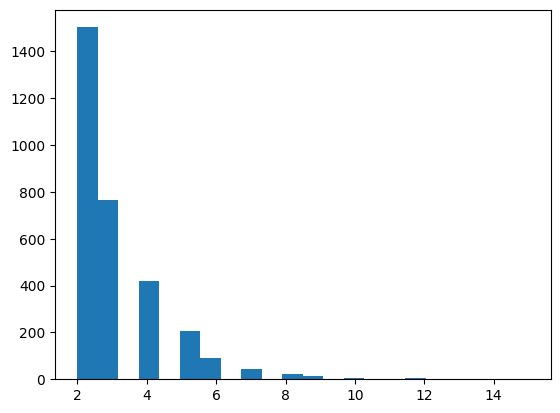

In [13]:
plt.hist(CellContainer_obj.metadata_training.total_counts, bins=22)
plt.show()

## Create global spatial expression matrix

In [21]:
def build_input_CNN_global(img_, seg_, D_, scaling_factor):
    image_global = resize_local_mean(img_, (128,128))
    image_global_n = normalize_img(image_global)
    # Create A_global
    D_ = D_.assign(y_=pd.Series(np.array(D_.y / scaling_factor, dtype=int)))
    D_ = D_.assign(x_=pd.Series(np.array(D_.x / scaling_factor, dtype=int)))
    gene_names = CellContainer_obj.gene_names
    A_global = np.zeros((len(gene_names),128,128))
    for g, gene in enumerate(gene_names):
        gene_count_1gene = D_.iloc[np.array(D_.name == gene)]
        for i in range(gene_count_1gene.shape[0]):
            x=gene_count_1gene.iloc[i]['x_']
            y=gene_count_1gene.iloc[i]['y_']
            A_global[g,x,y] += 1
    # Generate mask and average per window
    mask = seg_.copy()
    mask[mask>0] = 1
    mask = np.array(mask)
    mask_global = resize_local_mean(mask, (128,128))
    # 3D tensor used as input for CNN 
    input_CNN_global = torch.tensor(np.concatenate(( mask_global.reshape((1,) + mask_global.shape), 
                                              mask_global.reshape((1,) + mask_global.shape),
                                              image_global_n.reshape((1,) + image_global_n.shape),
                                              A_global )))
    return input_CNN_global

In [22]:
scaling_factor = 14000/128
input_CNN_global = build_input_CNN_global(img_n, seg, D, scaling_factor)

In [23]:
input_CNN_global.shape

torch.Size([190, 128, 128])

## Launch model

In [24]:
# Define variables 
learning_rate = 0.2#0.0005
n_cells = CellContainer_obj.n_cells_considered
num_epochs = 50
tau=0.5
n_cells_per_batch=12 ; e=64

# Generate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FullNet(n_genes=CellContainer_obj.S.shape[0], latent_variable_dim=CellContainer_obj.S.shape[1],
                e=64, size_pooling1=4, size_pooling2=2, batch_size=n_cells_per_batch).to(device).double()
criterion = nn.PoissonNLLLoss(log_input=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=num_epochs)

# Probability distribution of cell-type expression
S_n = torch.tensor(np.array(S / S.sum()))

In [25]:
# Create arrays to store results
all_x_hats = np.zeros((len(CellContainer_obj.gene_names), n_cells_per_batch, num_epochs))
all_pis =  np.zeros((S.shape[1], n_cells_per_batch, num_epochs))
all_zs = np.zeros((S.shape[1], n_cells_per_batch, num_epochs))
all_loss = np.zeros((n_cells_per_batch, num_epochs))

cell_type_sizes = CellContainer_obj.S.sum()
all_rank_average, all_accuracy = [], []

# Launch the training with num_epochs Epochs
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}, iterating over cells...')

    # Generate new mini-batch of cells 
    cell_subset = random.sample(CellContainer_obj.cells_training, n_cells_per_batch)
    
    ### Prepare local CNN input ###
    input_tensor = torch.tensor(np.zeros(shape=(n_cells_per_batch,189,e*2,e*2)) )
    output_tensor = torch.tensor(np.zeros(shape=(n_cells_per_batch,187)))
    all_min_z = np.zeros((S_tensor.shape[1], n_cells_per_batch))
    all_min_loss = np.zeros(n_cells_per_batch)
    #logger('Build new mini-batch')
    print('Build new mini-batch')
    for c, cell in enumerate(cell_subset):
        # For now, we ignore cells on the boarder of the image
        if cell.on_boarder: 
            continue

        # prepare input data
        x_true = cell.x.clone().detach().double()
        D_ = CellContainer_obj.D
        sel_window = (D_.y > cell.y_start) & (D_.y < cell.y_end) & (D_.x > cell.x_start) & (D_.x < cell.x_end)
        D_sub = D_.iloc[np.array(sel_window)].copy()
        seg_ = CellContainer_obj.seg[cell.x_start:cell.x_end,cell.y_start:cell.y_end]
        img_ = CellContainer_obj.img[cell.x_start:cell.x_end,cell.y_start:cell.y_end]
        input_cnn = build_input_CNN(D_sub, seg_, img_, CellContainer_obj.gene_names, cell)
        # Store CNN input in a dictionnary
        input_tensor[c,:,:,:] = input_cnn
        output_tensor[c,:] = x_true
        progress = (c + 1) / n_cells_per_batch
        drawProgressBar(progress)
        # find minimum loss pure cell-type
        min_loss = 100.0
        for k in range(S_n.shape[1]):
            loss_k = criterion(S_n[:,k], x_true)
            if loss_k.item() < min_loss:
                min_loss = loss_k.item()
                z_kc = np.zeros(S_n.shape[1])
                z_kc[k] = 1
        all_min_loss[c] = min_loss
        all_min_z[:, c] = z_kc

    # Standardize input tensors 
    means = input_tensor[:,2:,:,:].mean(dim=(1,2,3), keepdim=True)
    stds = input_tensor[:,2:,:,:].std(dim=(1,2,3), keepdim=True)
    input_tensor_n = input_tensor.clone()
    input_tensor_n[:,2:,:,:] = (input_tensor[:,2:,:,:] - means) / stds
    input_tensor_n[:,0,:,:] = (input_tensor_n[:,0,:,:] - input_tensor_n[:,0,:,:].mean())/(input_tensor_n[:,0,:,:].std())
    input_tensor_n[:,1,:,:] = (input_tensor_n[:,1,:,:] - input_tensor_n[:,1,:,:].mean())/(input_tensor_n[:,1,:,:].std())
    
    
    ### Build global CNN input tensor ###
    input_tensor_global = torch.tensor(np.zeros(shape=(n_cells_per_batch,190,e*2,e*2)) )
    for c, cell in enumerate(cell_subset):
        # prepare input data
        x_position = int(cell.loc['x'] / scaling_factor)
        y_position = int(cell.loc['y'] / scaling_factor)
        seg_coi = torch.zeros((128,128))
        seg_coi[x_position, y_position] = 1
        input_CNN_global_copy = input_CNN_global.clone()
        input_CNN_global_copy[1,:,:] = torch.tensor(seg_coi)
        input_tensor_global[c,:,:,:] = input_CNN_global_copy.clone()
        
    means = input_tensor_global[:,3:,:,:].mean(dim=(1,2,3), keepdim=True)
    stds = input_tensor_global[:,3:,:,:].std(dim=(1,2,3), keepdim=True)
    input_tensor_global_n = input_tensor_global.clone()
    input_tensor_global_n[:,3:,:,:] = (input_tensor_global[:,3:,:,:] - means) / stds
    input_tensor_global_n[:,0,:,:] = (input_tensor_global_n[:,0,:,:] - input_tensor_global_n[:,0,:,:].mean())/(input_tensor_global_n[:,0,:,:].std())
    input_tensor_global_n[:,1,:,:] = (input_tensor_global_n[:,1,:,:] - input_tensor_global_n[:,1,:,:].mean())/(input_tensor_global_n[:,1,:,:].std())
    input_tensor_global_n[:,2,:,:] = (input_tensor_global_n[:,2,:,:] - input_tensor_global_n[:,2,:,:].mean())/(input_tensor_global_n[:,2,:,:].std())
    
    # forward pass
    mu_k, pi_kc_local, pi_kc_global, z_kc = model(input_tensor_n.to(device), input_tensor_global_n.to(device), S_n.to(device), tau)
    
    # L2 regularization
    l2_lambda = 1e-8
    l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
    
    # Calculating loss 
    loss=criterion(mu_k, output_tensor.T)
    loss_no_reg = loss.item()
    loss = loss + l2_lambda*l2_norm
    
    # backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    print('new LR:'+str(scheduler.get_last_lr()))
    
    # Summary
    print(f'Epoch {epoch+1}/{num_epochs}, Mean Loss = {loss_no_reg:.4f}, Mean Loss with reg = {loss.item():.4f}, best min loss = {all_min_loss.mean()}')
    rank_l = [] ; tp_count = 0
    for i in range(n_cells_per_batch):
        rank_l.append(pd.Series(z_kc[i,:].detach().numpy()).rank(ascending=False)[np.argmax(all_min_z[:,i])])
        if rank_l[i] == 1:
            tp_count+=1
    print('Mean rank of true cell type: '+str(np.mean(rank_l))+'/16')
    all_rank_average.append(np.mean(rank_l))
    print('Accuracy: '+str(tp_count/n_cells_per_batch))
    all_accuracy.append(tp_count/n_cells_per_batch)
    
    # Draw progress bar 
    progress = (epoch + 1) / num_epochs
    drawProgressBar(progress)
    
    # Debug
    # check gradient values - control for v wanishing gradients
    for name, param in model.named_parameters(): # Check gradient sum 
        print(name, param.grad.abs().sum())

Epoch 1, iterating over cells...
Build new mini-batch
[====================================================================================================] 100%

/Users/acoudray/Desktop/tmp_samba/phd/gioele_project/2212_spatial-sc/spatial-sc/spatial-sc-env/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


new LR:[0.19640000000000002]
Epoch 1/50, Mean Loss = 0.1233, Mean Loss with reg = 0.1233, best min loss = 0.09085479649777894
Mean rank of true cell type: 7.25/16
Accuracy: 0.16666666666666666
[==                                                                                                  ] 2%conv1.weight tensor(263.8133, dtype=torch.float64)
conv1.bias tensor(4.6418e-08, dtype=torch.float64)
conv2.weight tensor(1052.7516, dtype=torch.float64)
conv2.bias tensor(4.4118e-08, dtype=torch.float64)
bnorm1.weight tensor(0.3898, dtype=torch.float64)
bnorm1.bias tensor(3.0612, dtype=torch.float64)
bnorm2.weight tensor(0.2832, dtype=torch.float64)
bnorm2.bias tensor(3.2044, dtype=torch.float64)
conv3.weight tensor(776.8374, dtype=torch.float64)
conv3.bias tensor(4.6824e-08, dtype=torch.float64)
conv4.weight tensor(702.6283, dtype=torch.float64)
conv4.bias tensor(4.9191e-08, dtype=torch.float64)
bnorm3.weight tensor(0.2490, dtype=torch.float64)
bnorm3.bias tensor(0.2322, dtype=torch.float64)

Build new mini-batch
[====================================================================================================] 100%new LR:[0.18560000000000001]
Epoch 4/50, Mean Loss = 0.1484, Mean Loss with reg = 0.1881, best min loss = 0.12106054418023504
Mean rank of true cell type: 9.0/16
Accuracy: 0.0
[========                                                                                            ] 8%conv1.weight tensor(0.0028, dtype=torch.float64)
conv1.bias tensor(3.3892e-09, dtype=torch.float64)
conv2.weight tensor(0.0028, dtype=torch.float64)
conv2.bias tensor(3.2024e-09, dtype=torch.float64)
bnorm1.weight tensor(3.7835e-06, dtype=torch.float64)
bnorm1.bias tensor(1.6270e-06, dtype=torch.float64)
bnorm2.weight tensor(3.7146e-06, dtype=torch.float64)
bnorm2.bias tensor(1.6270e-06, dtype=torch.float64)
conv3.weight tensor(0.0028, dtype=torch.float64)
conv3.bias tensor(3.4238e-09, dtype=torch.float64)
conv4.weight tensor(0.0028, dtype=torch.float64)
conv4.bias tensor(3.6292e-09, 

Build new mini-batch
[====================================================================================================] 100%new LR:[0.1748]
Epoch 7/50, Mean Loss = 0.1328, Mean Loss with reg = 0.2178, best min loss = 0.10997740083807477
Mean rank of true cell type: 7.666666666666667/16
Accuracy: 0.16666666666666666
[==============                                                                                      ] 14%conv1.weight tensor(0.0040, dtype=torch.float64)
conv1.bias tensor(1.3355e-08, dtype=torch.float64)
conv2.weight tensor(0.0041, dtype=torch.float64)
conv2.bias tensor(1.2703e-08, dtype=torch.float64)
bnorm1.weight tensor(3.7745e-06, dtype=torch.float64)
bnorm1.bias tensor(2.3841e-06, dtype=torch.float64)
bnorm2.weight tensor(3.6735e-06, dtype=torch.float64)
bnorm2.bias tensor(2.3840e-06, dtype=torch.float64)
conv3.weight tensor(0.0041, dtype=torch.float64)
conv3.bias tensor(1.3469e-08, dtype=torch.float64)
conv4.weight tensor(0.0041, dtype=torch.float64)
conv4.bias t

Build new mini-batch
[====================================================================================================] 100%new LR:[0.164]
Epoch 10/50, Mean Loss = 0.1342, Mean Loss with reg = 0.2551, best min loss = 0.1094227649885343
Mean rank of true cell type: 8.333333333333334/16
Accuracy: 0.08333333333333333
[====================                                                                                ] 20%conv1.weight tensor(0.0048, dtype=torch.float64)
conv1.bias tensor(1.5276e-08, dtype=torch.float64)
conv2.weight tensor(0.0048, dtype=torch.float64)
conv2.bias tensor(1.4518e-08, dtype=torch.float64)
bnorm1.weight tensor(3.7620e-06, dtype=torch.float64)
bnorm1.bias tensor(2.8466e-06, dtype=torch.float64)
bnorm2.weight tensor(3.6414e-06, dtype=torch.float64)
bnorm2.bias tensor(2.8465e-06, dtype=torch.float64)
conv3.weight tensor(0.0048, dtype=torch.float64)
conv3.bias tensor(1.5410e-08, dtype=torch.float64)
conv4.weight tensor(0.0048, dtype=torch.float64)
conv4.bias te

Build new mini-batch
[====================================================================================================] 100%new LR:[0.1532]
Epoch 13/50, Mean Loss = 0.1695, Mean Loss with reg = 0.3171, best min loss = 0.141356834861049
Mean rank of true cell type: 7.0/16
Accuracy: 0.25
[==========================                                                                          ] 26%conv1.weight tensor(0.0053, dtype=torch.float64)
conv1.bias tensor(1.0612e-08, dtype=torch.float64)
conv2.weight tensor(0.0054, dtype=torch.float64)
conv2.bias tensor(1.0077e-08, dtype=torch.float64)
bnorm1.weight tensor(3.7482e-06, dtype=torch.float64)
bnorm1.bias tensor(3.1483e-06, dtype=torch.float64)
bnorm2.weight tensor(3.6149e-06, dtype=torch.float64)
bnorm2.bias tensor(3.1482e-06, dtype=torch.float64)
conv3.weight tensor(0.0054, dtype=torch.float64)
conv3.bias tensor(1.0707e-08, dtype=torch.float64)
conv4.weight tensor(0.0054, dtype=torch.float64)
conv4.bias tensor(1.1264e-08, dtype=torch.

Build new mini-batch
[====================================================================================================] 100%new LR:[0.14240000000000003]
Epoch 16/50, Mean Loss = 0.1065, Mean Loss with reg = 0.2731, best min loss = 0.07761428622983198
Mean rank of true cell type: 9.0/16
Accuracy: 0.0
[================================                                                                    ] 32%conv1.weight tensor(0.0056, dtype=torch.float64)
conv1.bias tensor(4.4422e-09, dtype=torch.float64)
conv2.weight tensor(0.0057, dtype=torch.float64)
conv2.bias tensor(4.2100e-09, dtype=torch.float64)
bnorm1.weight tensor(3.7341e-06, dtype=torch.float64)
bnorm1.bias tensor(3.3496e-06, dtype=torch.float64)
bnorm2.weight tensor(3.5922e-06, dtype=torch.float64)
bnorm2.bias tensor(3.3495e-06, dtype=torch.float64)
conv3.weight tensor(0.0057, dtype=torch.float64)
conv3.bias tensor(4.4842e-09, dtype=torch.float64)
conv4.weight tensor(0.0057, dtype=torch.float64)
conv4.bias tensor(4.7315e-09

Build new mini-batch
[====================================================================================================] 100%new LR:[0.13160000000000005]
Epoch 19/50, Mean Loss = 0.1311, Mean Loss with reg = 0.3110, best min loss = 0.10038136913000854
Mean rank of true cell type: 8.333333333333334/16
Accuracy: 0.08333333333333333
[======================================                                                              ] 38%conv1.weight tensor(0.0058, dtype=torch.float64)
conv1.bias tensor(6.4071e-10, dtype=torch.float64)
conv2.weight tensor(0.0059, dtype=torch.float64)
conv2.bias tensor(6.1955e-10, dtype=torch.float64)
bnorm1.weight tensor(3.7203e-06, dtype=torch.float64)
bnorm1.bias tensor(3.4845e-06, dtype=torch.float64)
bnorm2.weight tensor(3.5726e-06, dtype=torch.float64)
bnorm2.bias tensor(3.4843e-06, dtype=torch.float64)
conv3.weight tensor(0.0059, dtype=torch.float64)
conv3.bias tensor(6.4344e-10, dtype=torch.float64)
conv4.weight tensor(0.0059, dtype=torch.float64

Build new mini-batch
[====================================================================================================] 100%new LR:[0.12080000000000006]
Epoch 22/50, Mean Loss = 0.1359, Mean Loss with reg = 0.3247, best min loss = 0.10919217655337649
Mean rank of true cell type: 9.0/16
Accuracy: 0.0
[============================================                                                        ] 44%conv1.weight tensor(0.0059, dtype=torch.float64)
conv1.bias tensor(3.7429e-09, dtype=torch.float64)
conv2.weight tensor(0.0061, dtype=torch.float64)
conv2.bias tensor(3.5645e-09, dtype=torch.float64)
bnorm1.weight tensor(3.7069e-06, dtype=torch.float64)
bnorm1.bias tensor(3.5742e-06, dtype=torch.float64)
bnorm2.weight tensor(3.5554e-06, dtype=torch.float64)
bnorm2.bias tensor(3.5740e-06, dtype=torch.float64)
conv3.weight tensor(0.0061, dtype=torch.float64)
conv3.bias tensor(3.7736e-09, dtype=torch.float64)
conv4.weight tensor(0.0061, dtype=torch.float64)
conv4.bias tensor(3.9520e-09

Build new mini-batch
[====================================================================================================] 100%new LR:[0.11000000000000006]
Epoch 25/50, Mean Loss = 0.1531, Mean Loss with reg = 0.3476, best min loss = 0.13006628329894912
Mean rank of true cell type: 7.0/16
Accuracy: 0.25
[==================================================                                                  ] 50%conv1.weight tensor(0.0060, dtype=torch.float64)
conv1.bias tensor(4.9577e-09, dtype=torch.float64)
conv2.weight tensor(0.0062, dtype=torch.float64)
conv2.bias tensor(4.7151e-09, dtype=torch.float64)
bnorm1.weight tensor(3.6943e-06, dtype=torch.float64)
bnorm1.bias tensor(3.6329e-06, dtype=torch.float64)
bnorm2.weight tensor(3.5402e-06, dtype=torch.float64)
bnorm2.bias tensor(3.6326e-06, dtype=torch.float64)
conv3.weight tensor(0.0062, dtype=torch.float64)
conv3.bias tensor(5.0001e-09, dtype=torch.float64)
conv4.weight tensor(0.0062, dtype=torch.float64)
conv4.bias tensor(5.2472e-0

Build new mini-batch
[====================================================================================================] 100%new LR:[0.09920000000000004]
Epoch 28/50, Mean Loss = 0.1314, Mean Loss with reg = 0.3295, best min loss = 0.11147384715405671
Mean rank of true cell type: 8.333333333333334/16
Accuracy: 0.08333333333333333
[========================================================                                            ] 56%conv1.weight tensor(0.0060, dtype=torch.float64)
conv1.bias tensor(4.8155e-09, dtype=torch.float64)
conv2.weight tensor(0.0062, dtype=torch.float64)
conv2.bias tensor(4.5766e-09, dtype=torch.float64)
bnorm1.weight tensor(3.7261e-06, dtype=torch.float64)
bnorm1.bias tensor(3.6702e-06, dtype=torch.float64)
bnorm2.weight tensor(3.5722e-06, dtype=torch.float64)
bnorm2.bias tensor(3.6699e-06, dtype=torch.float64)
conv3.weight tensor(0.0062, dtype=torch.float64)
conv3.bias tensor(4.8576e-09, dtype=torch.float64)
conv4.weight tensor(0.0062, dtype=torch.float64

Build new mini-batch
[====================================================================================================] 100%new LR:[0.08840000000000003]
Epoch 31/50, Mean Loss = 0.1354, Mean Loss with reg = 0.3355, best min loss = 0.10197782949025731
Mean rank of true cell type: 9.0/16
Accuracy: 0.0
[==============================================================                                      ] 62%conv1.weight tensor(0.0060, dtype=torch.float64)
conv1.bias tensor(3.9236e-09, dtype=torch.float64)
conv2.weight tensor(0.0063, dtype=torch.float64)
conv2.bias tensor(3.7266e-09, dtype=torch.float64)
bnorm1.weight tensor(3.7484e-06, dtype=torch.float64)
bnorm1.bias tensor(3.6929e-06, dtype=torch.float64)
bnorm2.weight tensor(3.5949e-06, dtype=torch.float64)
bnorm2.bias tensor(3.6925e-06, dtype=torch.float64)
conv3.weight tensor(0.0063, dtype=torch.float64)
conv3.bias tensor(3.9585e-09, dtype=torch.float64)
conv4.weight tensor(0.0063, dtype=torch.float64)
conv4.bias tensor(4.1627e-09

Build new mini-batch
[====================================================================================================] 100%new LR:[0.07760000000000003]
Epoch 34/50, Mean Loss = 0.1714, Mean Loss with reg = 0.3725, best min loss = 0.134449088098579
Mean rank of true cell type: 8.333333333333334/16
Accuracy: 0.08333333333333333
[====================================================================                                ] 68%conv1.weight tensor(0.0060, dtype=torch.float64)
conv1.bias tensor(2.7768e-09, dtype=torch.float64)
conv2.weight tensor(0.0063, dtype=torch.float64)
conv2.bias tensor(2.6355e-09, dtype=torch.float64)
bnorm1.weight tensor(3.7609e-06, dtype=torch.float64)
bnorm1.bias tensor(3.7058e-06, dtype=torch.float64)
bnorm2.weight tensor(3.6077e-06, dtype=torch.float64)
bnorm2.bias tensor(3.7053e-06, dtype=torch.float64)
conv3.weight tensor(0.0063, dtype=torch.float64)
conv3.bias tensor(2.8021e-09, dtype=torch.float64)
conv4.weight tensor(0.0063, dtype=torch.float64)


Build new mini-batch
[====================================================================================================] 100%new LR:[0.06680000000000003]
Epoch 37/50, Mean Loss = 0.1240, Mean Loss with reg = 0.3254, best min loss = 0.09938640909079903
Mean rank of true cell type: 8.333333333333334/16
Accuracy: 0.08333333333333333
[==========================================================================                          ] 74%conv1.weight tensor(0.0060, dtype=torch.float64)
conv1.bias tensor(1.6950e-09, dtype=torch.float64)
conv2.weight tensor(0.0063, dtype=torch.float64)
conv2.bias tensor(1.6069e-09, dtype=torch.float64)
bnorm1.weight tensor(3.7669e-06, dtype=torch.float64)
bnorm1.bias tensor(3.7122e-06, dtype=torch.float64)
bnorm2.weight tensor(3.6141e-06, dtype=torch.float64)
bnorm2.bias tensor(3.7117e-06, dtype=torch.float64)
conv3.weight tensor(0.0063, dtype=torch.float64)
conv3.bias tensor(1.7109e-09, dtype=torch.float64)
conv4.weight tensor(0.0063, dtype=torch.float64

KeyboardInterrupt: 

In [438]:
torch.save(model.state_dict(), '../models/model_global_trial.pt')

In [424]:
input_tensor_global = torch.tensor(np.zeros(shape=(n_cells_per_batch,190,e*2,e*2)) )
means = input_tensor_global[:,3:,:,:].mean(dim=(1,2,3), keepdim=True)
stds = input_tensor_global[:,3:,:,:].std(dim=(1,2,3), keepdim=True)
input_tensor_global_n = input_tensor_global.clone().detach()
input_tensor_global_n[:,3:,:,:] = (input_tensor_global[:,3:,:,:] - means) / stds

10.666666666666666

In [436]:
# Create arrays to store results
all_pi_globals = np.zeros((128,128,16))
# Launch the training with num_epochs Epochs
for i in range(128):
    print(i)
    for j in range(int(128/n_cells_per_batch)):

        ### Build global CNN input tensor ###
        for c in range(n_cells_per_batch):
            seg_coi[i, j*n_cells_per_batch+c] = 1
            input_tensor_global_n[c,1,:,:] = torch.tensor(seg_coi)
        input_tensor_global_n[:,1,:,:] = (input_tensor_global_n[:,1,:,:] - input_tensor_global_n[:,1,:,:].mean())/(input_tensor_global_n[:,1,:,:].std())

        # forward pass
        mu_k, pi_kc_local, pi_kc_global, z_kc = model(input_tensor_n.to(device), input_tensor_global_n.to(device), S_n.to(device), tau)
        all_pi_globals[i,j*n_cells_per_batch:(j+1)*n_cells_per_batch,:] = pi_kc_global.detach().numpy()


0


/Users/acoudray/Desktop/tmp_samba/phd/gioele_project/2212_spatial-sc/spatial-sc/spatial-sc-env/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88


KeyboardInterrupt: 

In [435]:
int(128/n_cells_per_batch)

10

In [433]:
n_cells_per_batch

12

In [549]:
## Apply model to make predictions 
# iterate over cells
total_cell_number = len(CellContainer_obj.cells)
total_batch_number = int(total_cell_number/n_cells_per_batch)+1
all_zs, all_pis = np.zeros((total_cell_number, 16)), np.zeros((total_cell_number, 16))
all_accuracy, all_ranks, all_loss = np.zeros(total_cell_number), np.zeros(total_cell_number), np.zeros(total_cell_number)
for i in range(total_batch_number):
    print('cell subset '+str(i)+'/'+str(total_batch_number))
    first_cell = i*n_cells_per_batch
    last_cell  = min((i+1)*n_cells_per_batch, total_cell_number)
    cell_subset = CellContainer_obj.cells[first_cell:last_cell]
    print(str(first_cell)+':'+str(last_cell))
    
    # Prepare CNN for each cells 
    input_tensor = torch.tensor(np.zeros(shape=(n_cells_per_batch,189,e*2,e*2)) )
    output_tensor = torch.tensor(np.zeros(shape=(n_cells_per_batch,187)))
    all_min_k = np.zeros(n_cells_per_batch)
    all_min_loss = np.zeros(n_cells_per_batch)
    for c, cell in enumerate(cell_subset):
        # prepare input data
        x_true = cell.x.clone().detach().double()
        D_ = CellContainer_obj.D
        sel_window = (D_.y > cell.y_start) & (D_.y < cell.y_end) & (D_.x > cell.x_start) & (D_.x < cell.x_end)
        D_sub = D_.iloc[np.array(sel_window)].copy()
        seg_ = CellContainer_obj.seg[cell.x_start:cell.x_end,cell.y_start:cell.y_end]
        img_ = CellContainer_obj.img[cell.x_start:cell.x_end,cell.y_start:cell.y_end]
        input_cnn = build_input_CNN(D_sub, seg_, img_, CellContainer_obj.gene_names, cell)
        # Store CNN input in a dictionnary
        input_tensor[c,:,:,:] = input_cnn
        output_tensor[c,:] = x_true
        progress = (c + 1) / n_cells_per_batch
        drawProgressBar(progress)
        # find minimum loss pure cell-type
        all_min_loss[c] = cell.min_loss
        all_min_k[c] = cell.min_k

    # Standardize input tensors 
    means = input_tensor[:,2:,:,:].mean(dim=(1,2,3), keepdim=True)
    stds = input_tensor[:,2:,:,:].std(dim=(1,2,3), keepdim=True)
    input_tensor_n = input_tensor.clone()
    input_tensor_n[:,2:,:,:] = (input_tensor[:,2:,:,:] - means) / stds
    input_tensor_n[:,0,:,:] = (input_tensor_n[:,0,:,:] - input_tensor_n[:,0,:,:].mean())/(input_tensor_n[:,0,:,:].std())
    input_tensor_n[:,1,:,:] = (input_tensor_n[:,1,:,:] - input_tensor_n[:,1,:,:].mean())/(input_tensor_n[:,1,:,:].std())

    # forward pass
    mu_k, pi_kc, z_kc = model(input_tensor_n.to(device), S_n.to(device), tau)
    
    # Computing loss 
    loss=criterion(mu_k, output_tensor.T)
    
    # Summary
    print(f'Prediction of mini-batch {i+1}/{total_batch_number}, Mean Loss = {loss.item():.4f}, best min loss = {all_min_loss.mean()}')
    rank_l = [] ; tp_count = 0
    for i in range(n_cells_per_batch):
        pred_celltype = np.argmax(z_kc)
        true_celltype = all_min_k[i]
        if pred_celltype == true_celltype:
            tp_count+=1
    print('Mean rank of true cell type: '+str(np.mean(rank_l))+'/16')
    print('Accuracy: '+str(tp_count/n_cells_per_batch))
    
    # Save results
    all_zs[first_cell:last_cell,:] = z_kc.cpu().detach().clone()
    all_pis[first_cell:last_cell,:] = pi_kc.cpu().detach().clone()
    all_accuracy[first_cell:last_cell] = tp_count/n_cells_per_batch
    all_ranks[first_cell:last_cell] = np.mean(rank_l)
    all_loss[first_cell:last_cell] = loss.item()

cell subset 0/145
0:12
[====================================================================================================] 100%

In [ ]:
z_kc

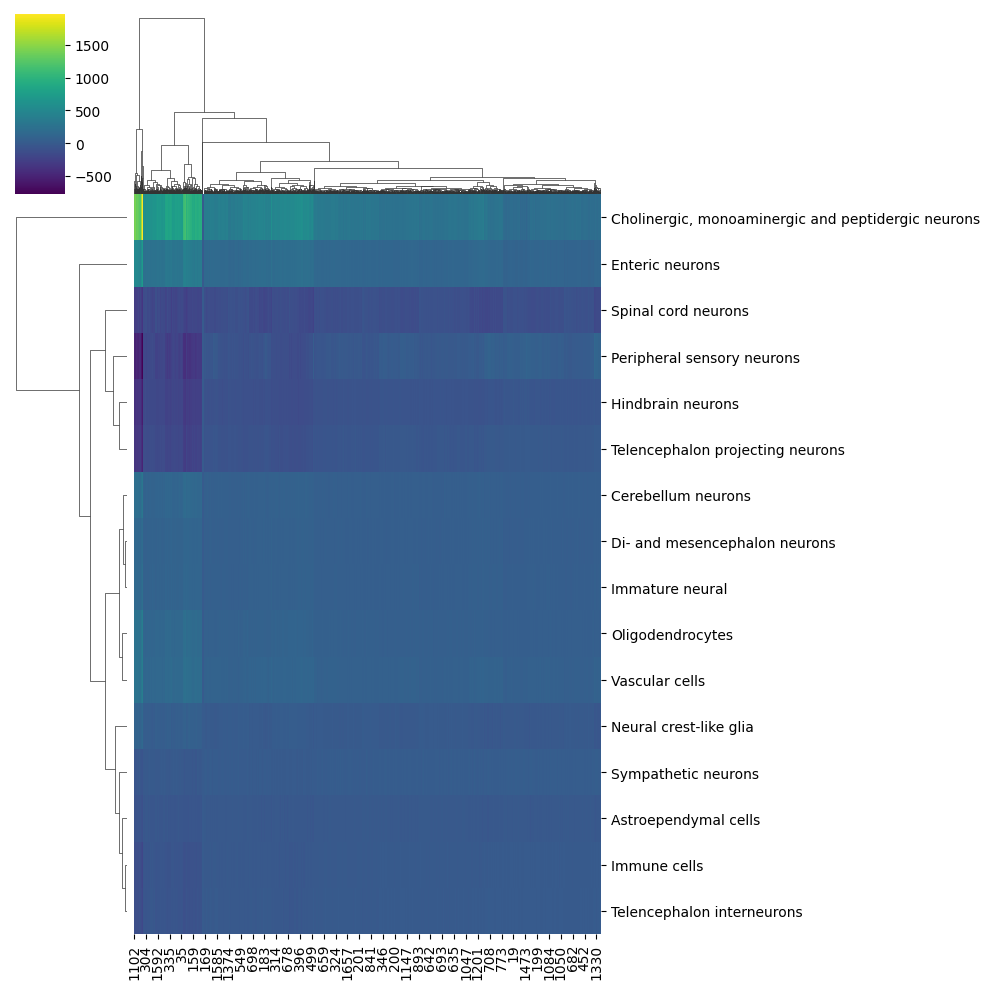

In [240]:
clustermap(pd.DataFrame(all_pis, columns=S.columns).T, cmap='viridis')

In [ ]:
all_pis[:,:,epoch]

In [ ]:
seg_ = seg.copy() * -1
for c, cell in enumerate(CellContainer_obj.cells):
    #if cell.on_boarder: 
    #    continue
    cell.z = all_min_z[:, 3]
    #cell.pi = all_pis[:, c, 9]
    cell_label = cell.label*-1
    seg_[seg_ == cell_label] = np.argmax(cell.z)+1
    
    progress = (c + 1) / n_cells
    drawProgressBar(progress)
        
    #if c >= n_cells-1:
    #    break

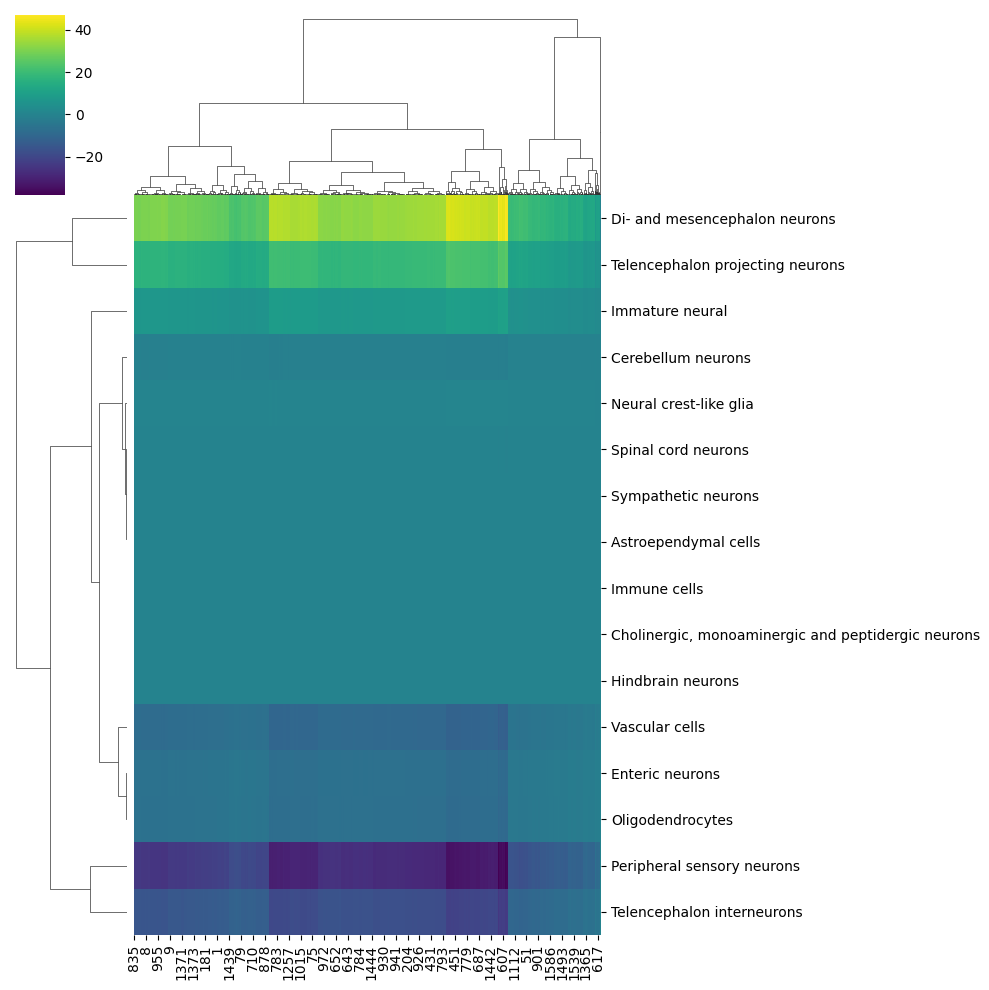

In [678]:
clustermap(pd.DataFrame(all_pis[:,:,epoch], index=S.columns), cmap='viridis')

In [307]:
# Prepare CNN for each cells 
criterion = nn.PoissonNLLLoss(log_input=False)
n_cells = len(CellContainer_obj.cells_training)
all_min_loss = np.ones(n_cells)
celltypes_labs = np.ones(n_cells)
all_min_z = np.zeros((S_tensor.shape[1], n_cells))
all_z_loss = np.zeros((S_tensor.shape[1], n_cells))
S_n = torch.tensor(np.array(S / S.sum()))
below_threshold=0
below_threshold_bool = np.zeros(n_cells)
for c, cell in enumerate(CellContainer_obj.cells_training):
    # For now, we ignore cells on the boarder of the image
    if cell.on_boarder: 
        continue
    
    # find minimum loss pure cell-type
    x_true = cell.x.clone().detach().double()
    rna_counts = int(sum(x_true).numpy())
    min_loss = 100.0
    loss_z_k = np.zeros(S_n.shape[1]) ; min_k = 0
    for k in range(S_n.shape[1]):
        loss_k = criterion(S_n[:,k], x_true)
        loss_z_k[k] = loss_k
        if loss_k.item() < min_loss:
            min_loss = loss_k.item()
            z_kc = np.zeros(S_n.shape[1])
            z_kc[k] = 1
            min_k = k
    all_min_loss[c] = min_loss
    all_min_z[:, c] = z_kc
    all_z_loss[:, c]= loss_z_k
    celltypes_labs[c] = min_k
    loss_cutoff = pd_loss_cutoff.iloc[min_k][rna_counts]
    if min_loss < loss_cutoff or rna_counts >= 4:
        below_threshold+=1
        below_threshold_bool[c] = 1
    progress = (c + 1) / n_cells
    drawProgressBar(progress)

[====================================================================================================] 100%

In [308]:
n_cells

8937

In [323]:
rare_celltype = np.where(np.unique(celltypes_labs[below_threshold_bool == 1], return_counts=True)[1] < 100)[0]

In [313]:
np.unique(celltypes_labs, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15.]),
 array([ 356,  335, 1745, 1217,  145,  597, 2367,   16,  684,  213,   71,
          83,   79,  123,  819,   87]))

In [272]:
S.columns[min_k]

'Cholinergic, monoaminergic and peptidergic neurons'

In [274]:
pd_loss_cutoff.loc[S.columns[min_k]][rna_counts]

0.2226298591721507

In [265]:
int(sum(x_true).numpy())

9

In [551]:
all_min_z.shape

(16, 1734)

## Loss function from the gene point of view

We can also use a poisson distribution for each gene with 1 or more counts, and ignoring all other genes:

In [433]:
# randomly choose one cell-type out of K
K = S_n.shape[1] ; G = S_n.shape[0]
max_counts = 27 ; iterations = 100
# iterate over cell-types
#res_ = np.zeros((K, max_counts))
for k in range(K):
    print('cell type '+S.columns[k])
    z_true = np.zeros(K)
    z_true[k] = 1
    for c in range(max_counts):
        good_pred = 0
        for a in range(iterations):
            x_c = np.zeros(G)
            for b in range(c):
                idx_g = random.choices(range(G), weights = S_n[:,k])
                x_c[idx_g] += 1
            non_zeros = np.nonzero(x_c)[0]
            S_g = np.zeros(16)
            for n in non_zeros:
                weight_ = x_c[n]
                S_g += (S_n[n,:]/torch.sum(S_n[n,:])).numpy()
            S_g = S_g / sum(x_c)
            z_pred = np.zeros(S_n.shape[1])
            z_pred[np.argmax(S_g)] = 1
            if all(z_pred == z_true):
                good_pred+=1
        res_[k,c] = good_pred / iterations
        print('Counts='+str(c)+', Accuracy='+ str(good_pred / iterations))

cell type Astroependymal cells
cell type Astroependymal cells, Counts=0, Accuracy=1.0
cell type Astroependymal cells, Counts=1, Accuracy=0.68


/Users/acoudray/Desktop/tmp_samba/phd/gioele_project/2212_spatial-sc/spatial-sc/spatial-sc-env/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


cell type Astroependymal cells, Counts=2, Accuracy=0.82
cell type Astroependymal cells, Counts=3, Accuracy=0.87
cell type Astroependymal cells, Counts=4, Accuracy=0.94
cell type Astroependymal cells, Counts=5, Accuracy=0.96
cell type Astroependymal cells, Counts=6, Accuracy=0.99
cell type Astroependymal cells, Counts=7, Accuracy=0.98
cell type Astroependymal cells, Counts=8, Accuracy=0.97
cell type Astroependymal cells, Counts=9, Accuracy=0.99
cell type Astroependymal cells, Counts=10, Accuracy=0.99
cell type Astroependymal cells, Counts=11, Accuracy=1.0
cell type Astroependymal cells, Counts=12, Accuracy=0.99
cell type Astroependymal cells, Counts=13, Accuracy=0.99
cell type Astroependymal cells, Counts=14, Accuracy=1.0
cell type Astroependymal cells, Counts=15, Accuracy=1.0
cell type Astroependymal cells, Counts=16, Accuracy=1.0
cell type Astroependymal cells, Counts=17, Accuracy=1.0
cell type Astroependymal cells, Counts=18, Accuracy=1.0
cell type Astroependymal cells, Counts=19, Ac

cell type Enteric neurons, Counts=21, Accuracy=0.96
cell type Enteric neurons, Counts=22, Accuracy=0.95
cell type Enteric neurons, Counts=23, Accuracy=0.94
cell type Enteric neurons, Counts=24, Accuracy=0.97
cell type Enteric neurons, Counts=25, Accuracy=0.97
cell type Enteric neurons, Counts=26, Accuracy=0.95
cell type Hindbrain neurons
cell type Hindbrain neurons, Counts=0, Accuracy=0.0
cell type Hindbrain neurons, Counts=1, Accuracy=0.12
cell type Hindbrain neurons, Counts=2, Accuracy=0.23
cell type Hindbrain neurons, Counts=3, Accuracy=0.3
cell type Hindbrain neurons, Counts=4, Accuracy=0.39
cell type Hindbrain neurons, Counts=5, Accuracy=0.47
cell type Hindbrain neurons, Counts=6, Accuracy=0.55
cell type Hindbrain neurons, Counts=7, Accuracy=0.52
cell type Hindbrain neurons, Counts=8, Accuracy=0.65
cell type Hindbrain neurons, Counts=9, Accuracy=0.72
cell type Hindbrain neurons, Counts=10, Accuracy=0.8
cell type Hindbrain neurons, Counts=11, Accuracy=0.73
cell type Hindbrain neuro

cell type Peripheral sensory neurons, Counts=10, Accuracy=0.79
cell type Peripheral sensory neurons, Counts=11, Accuracy=0.83
cell type Peripheral sensory neurons, Counts=12, Accuracy=0.92
cell type Peripheral sensory neurons, Counts=13, Accuracy=0.77
cell type Peripheral sensory neurons, Counts=14, Accuracy=0.93
cell type Peripheral sensory neurons, Counts=15, Accuracy=0.89
cell type Peripheral sensory neurons, Counts=16, Accuracy=0.9
cell type Peripheral sensory neurons, Counts=17, Accuracy=0.89
cell type Peripheral sensory neurons, Counts=18, Accuracy=0.91
cell type Peripheral sensory neurons, Counts=19, Accuracy=0.9
cell type Peripheral sensory neurons, Counts=20, Accuracy=0.89
cell type Peripheral sensory neurons, Counts=21, Accuracy=0.82
cell type Peripheral sensory neurons, Counts=22, Accuracy=0.91
cell type Peripheral sensory neurons, Counts=23, Accuracy=0.91
cell type Peripheral sensory neurons, Counts=24, Accuracy=0.86
cell type Peripheral sensory neurons, Counts=25, Accuracy

cell type Vascular cells, Counts=9, Accuracy=1.0
cell type Vascular cells, Counts=10, Accuracy=1.0
cell type Vascular cells, Counts=11, Accuracy=1.0
cell type Vascular cells, Counts=12, Accuracy=1.0
cell type Vascular cells, Counts=13, Accuracy=1.0
cell type Vascular cells, Counts=14, Accuracy=1.0
cell type Vascular cells, Counts=15, Accuracy=1.0
cell type Vascular cells, Counts=16, Accuracy=1.0
cell type Vascular cells, Counts=17, Accuracy=1.0
cell type Vascular cells, Counts=18, Accuracy=1.0
cell type Vascular cells, Counts=19, Accuracy=1.0
cell type Vascular cells, Counts=20, Accuracy=1.0
cell type Vascular cells, Counts=21, Accuracy=1.0
cell type Vascular cells, Counts=22, Accuracy=1.0
cell type Vascular cells, Counts=23, Accuracy=1.0
cell type Vascular cells, Counts=24, Accuracy=1.0
cell type Vascular cells, Counts=25, Accuracy=1.0
cell type Vascular cells, Counts=26, Accuracy=1.0


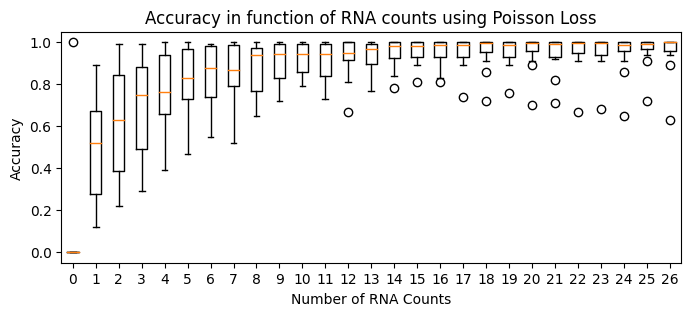

In [434]:
plt.figure(figsize=(8,3))
plt.boxplot(res_)
plt.xticks(np.arange(1,28), np.arange(0,27))
plt.xlabel('Number of RNA Counts') ; plt.ylabel('Accuracy')
plt.title('Accuracy in function of RNA counts using Poisson Loss per gene')
plt.show()

## Check informative genes with one count

In [98]:
# randomly choose one cell-type out of K
K = S_n.shape[1] ; G = S_n.shape[0]
max_counts = 27 ; iterations = 10000
# iterate over cell-types
res_poisson_ct = np.zeros((K, G))
tot_per_gene = np.zeros((K, G))
ratio_per_gene = np.zeros((K, G))
for k in range(K):
    print('cell type '+S.columns[k])
    z_true = np.zeros(K)
    z_true[k] = 1
    max_counts = 1
    good_pred = 0
    for a in range(iterations):
        x_c = np.zeros(G)
        for b in range(max_counts):
            idx_g = random.choices(range(G), weights = S_n[:,k])
            x_c[idx_g] += 1

        min_loss = 100.0
        z_pred = np.zeros(S_n.shape[1])
        for k_ in range(S_n.shape[1]):
            loss_k = criterion(S_n[:,k_], torch.tensor(x_c))
            if loss_k.item() < min_loss:
                min_loss = loss_k.item()
                z_pred = np.zeros(S_n.shape[1])
                z_pred[k_] = 1
        tot_per_gene[k, np.argmax(x_c)] +=1.0
        if all(z_pred == z_true):
            res_poisson_ct[k, np.argmax(x_c)] +=1.0
        
    for g in range(G):
        if tot_per_gene[k, g] > 0.0:
            ratio_per_gene[k, g] = float(res_poisson_ct[k, g]) / float(tot_per_gene[k, g])

cell type Astroependymal cells
cell type Cerebellum neurons
cell type Cholinergic, monoaminergic and peptidergic neurons
cell type Di- and mesencephalon neurons
cell type Enteric neurons
cell type Hindbrain neurons
cell type Immature neural
cell type Immune cells
cell type Neural crest-like glia
cell type Oligodendrocytes
cell type Peripheral sensory neurons
cell type Spinal cord neurons
cell type Sympathetic neurons
cell type Telencephalon interneurons
cell type Telencephalon projecting neurons
cell type Vascular cells


In [99]:
ratio_per_gene[0:10,0:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [107]:
ratio_mat = tot_per_gene / tot_per_gene.sum(axis=0)

/Users/acoudray/Desktop/tmp_samba/phd/gioele_project/2212_spatial-sc/spatial-sc/spatial-sc-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [129]:
tot_per_gene.sum(axis=0)

array([1.2090e+03, 1.6810e+03, 2.0600e+03, 3.7100e+02, 4.9200e+02,
       5.2400e+02, 5.1300e+02, 4.4400e+02, 7.2300e+02, 1.2010e+03,
       1.5400e+02, 2.2000e+01, 1.7280e+03, 5.8600e+02, 2.7200e+02,
       2.6400e+02, 4.7000e+01, 7.4800e+02, 3.3300e+02, 4.2000e+01,
       1.9500e+02, 2.7400e+02, 9.0000e+01, 1.1720e+03, 4.7800e+02,
       2.9660e+03, 2.1000e+02, 1.7900e+02, 1.7400e+02, 3.1500e+02,
       3.7500e+02, 1.6300e+02, 3.8800e+02, 6.8000e+01, 8.9600e+02,
       5.0000e+01, 1.1200e+02, 1.7800e+02, 7.7660e+03, 5.7000e+01,
       8.7000e+01, 2.9000e+02, 3.8400e+02, 1.5900e+02, 1.5800e+02,
       1.8000e+02, 3.1000e+01, 8.5100e+02, 2.9000e+01, 3.1400e+02,
       5.3000e+02, 1.7100e+02, 9.3000e+01, 8.0000e+00, 9.0000e+00,
       4.8900e+02, 2.5000e+01, 2.9000e+01, 2.7300e+02, 5.8000e+01,
       5.5000e+01, 3.2560e+03, 1.6000e+01, 6.5900e+02, 4.7900e+02,
       6.4100e+02, 3.1000e+02, 5.3900e+02, 6.0000e+01, 1.2350e+03,
       3.3600e+02, 3.1800e+02, 1.3210e+03, 8.5500e+02, 1.5000e

In [117]:
ratio_mat = pd.DataFrame(np.nan_to_num(ratio_mat), index=S.columns)

In [135]:
conf_genes = np.array(ratio_mat > 0.9).astype(int)

In [139]:
np.unique(conf_genes.sum(axis=0))

array([0, 1])

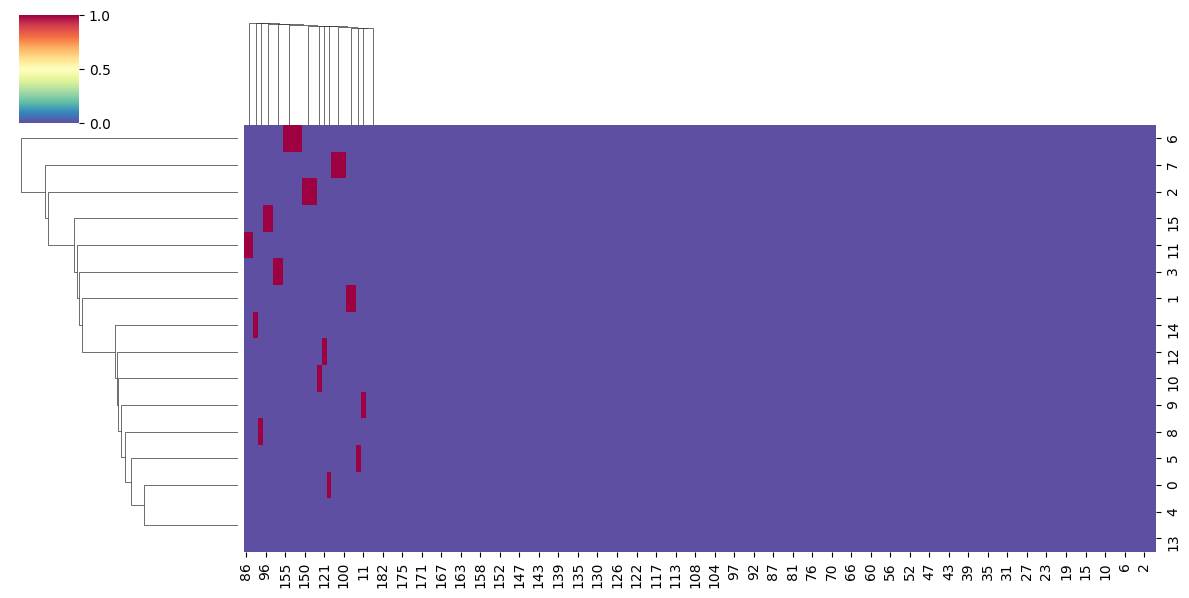

In [136]:
clustermap(conf_genes, figsize=(12,6), cmap='Spectral_r')


<Figure size 640x480 with 0 Axes>

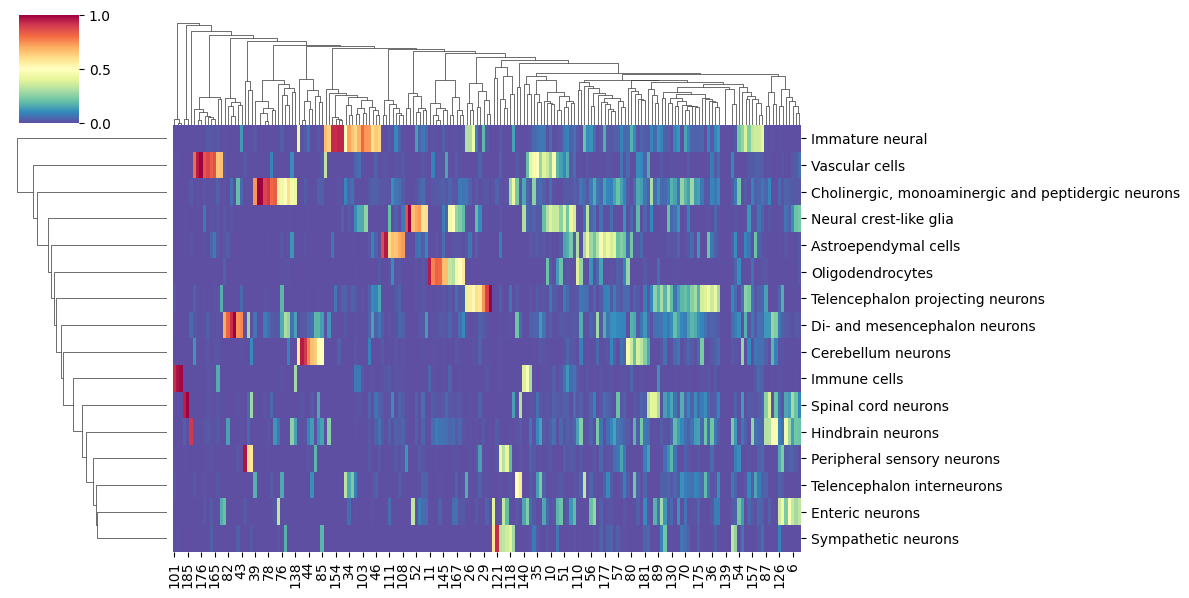

In [128]:
clustermap(ratio_mat, figsize=(12,6), cmap='Spectral_r')


In [126]:
np.max(ratio_mat, axis=1)

Astroependymal cells                                  0.958333
Cerebellum neurons                                    0.954386
Cholinergic, monoaminergic and peptidergic neurons    1.000000
Di- and mesencephalon neurons                         1.000000
Enteric neurons                                       0.476502
Hindbrain neurons                                     0.907956
Immature neural                                       0.939394
Immune cells                                          0.987812
Neural crest-like glia                                1.000000
Oligodendrocytes                                      0.954545
Peripheral sensory neurons                            0.968750
Spinal cord neurons                                   1.000000
Sympathetic neurons                                   0.926829
Telencephalon interneurons                            0.570435
Telencephalon projecting neurons                      1.000000
Vascular cells                                        1

## Try Cosine similarity loss

In [523]:
# randomly choose one cell-type out of K
K = S_n.shape[1] ; G = S_n.shape[0]
max_counts = 27 ; iterations = 100
# iterate over cell-types
res_cos_sim = np.zeros((K, max_counts))
for k in range(K):
    print('cell type '+S.columns[k])
    z_true = np.zeros(K)
    z_true[k] = 1
    for c in range(max_counts):
        good_pred = 0
        for a in range(iterations):
            x_c = np.zeros(G)
            for b in range(c):
                idx_g = random.choices(range(G), weights = S_n[:,k])
                x_c[idx_g] += 1
            min_loss = 100.0
            z_pred = np.zeros(S_n.shape[1])
            for k_ in range(S_n.shape[1]):
                loss_k = -1*cosine_similarity(S_n[:,k_], torch.tensor(x_c), dim=0)
                if loss_k.item() < min_loss:
                    min_loss = loss_k.item()
                    z_pred = np.zeros(S_n.shape[1])
                    z_pred[k_] = 1
            if all(z_pred == z_true):
                good_pred+=1
        res_cos_sim[k,c] = good_pred / iterations

cell type Astroependymal cells
cell type Cerebellum neurons
cell type Cholinergic, monoaminergic and peptidergic neurons
cell type Di- and mesencephalon neurons
cell type Enteric neurons
cell type Hindbrain neurons
cell type Immature neural
cell type Immune cells
cell type Neural crest-like glia
cell type Oligodendrocytes
cell type Peripheral sensory neurons
cell type Spinal cord neurons
cell type Sympathetic neurons
cell type Telencephalon interneurons
cell type Telencephalon projecting neurons
cell type Vascular cells


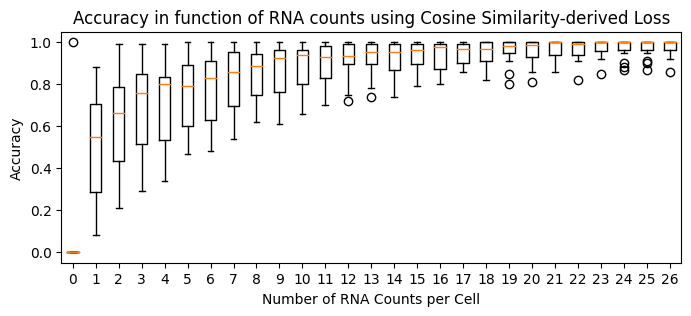

In [555]:
plt.figure(figsize=(8,3))
plt.boxplot(res_cos_sim)
plt.xticks(np.arange(1,28), np.arange(0,27))
plt.xlabel('Number of RNA Counts per Cell') ; plt.ylabel('Accuracy')
plt.title('Accuracy in function of RNA counts using Cosine Similarity-derived Loss')
plt.savefig('../results/sim_maxli/counts_vs_accuracy_cosine_loss.pdf', bbox_inches='tight')
plt.show()

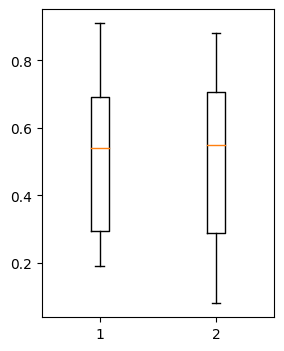

In [552]:
plt.figure(figsize=(3,4))
pd_df = pd.DataFrame(res_poisson_ct[:,1], columns=['poisson'])
pd_df['cosine'] = res_cos_sim[:,1]
plt.boxplot(pd_df)
plt.show()jlp;[']\
]=-0']

## Get total counts

In [248]:
all_x, all_y, all_test, all_label, all_counts = [], [], [], [], []
for cell in CellContainer_obj.cells:
    all_x.append(int(cell.loc.x))
    all_y.append(int(cell.loc.y))
    all_test.append(int(cell.testing))
    all_label.append(int(cell.label))
    all_counts.append(int(torch.sum(cell.x).detach().numpy()))

In [249]:
pd_counts = pd.DataFrame([CellContainer_obj.cell_labels, CellContainer_obj.train_test_list,
              all_x, all_y, all_counts],
             index=['cell_name', 'test_set', 'x', 'y', 'total_count']).T

(array([8.549e+03, 6.779e+03, 4.863e+03, 2.872e+03, 1.607e+03, 7.870e+02,
        4.040e+02, 1.980e+02, 1.040e+02, 5.100e+01, 2.700e+01, 1.500e+01,
        1.000e+01, 6.000e+00, 3.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26.]),
 <BarContainer object of 26 artists>)

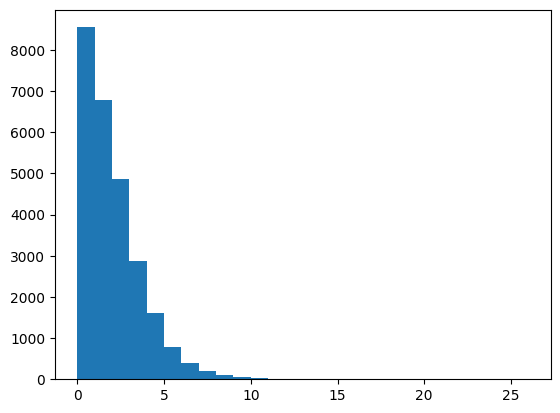

In [254]:
plt.hist(all_counts, bins=26)

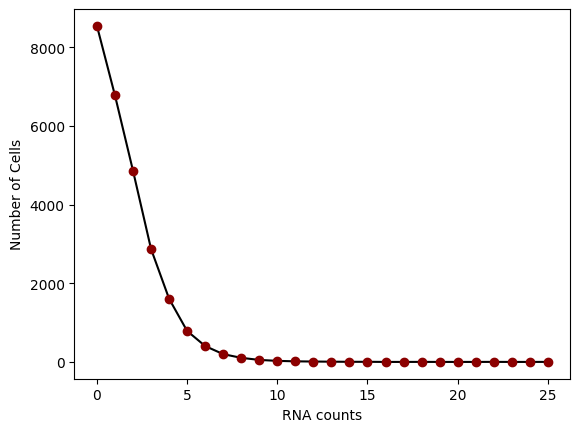

In [558]:
counts, bins = np.histogram(all_counts, bins=26)
plt.plot(bins[0:len(counts)], counts, color='black')
plt.plot(bins[0:len(counts)], counts, 'o', color='darkred')
plt.xlabel('RNA counts') ; plt.ylabel('Number of Cells')
plt.savefig('../results/sim_maxli/ncells_vs_rnacounts.pdf', bbox_inches='tight')
plt.show()

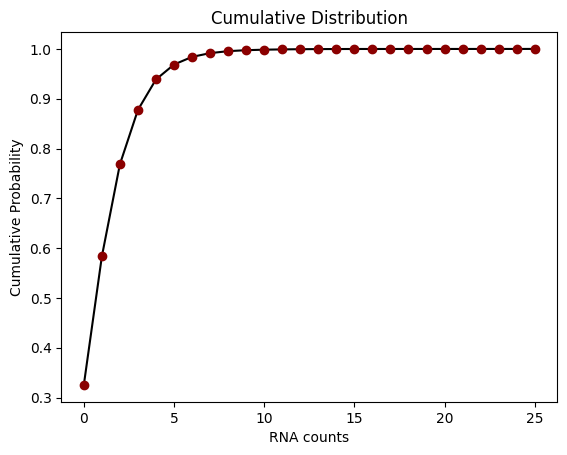

In [559]:
plt.plot(bins[0:len(counts)], np.cumsum(counts)/np.max(np.cumsum(counts)), c='black')
plt.plot(bins[0:len(counts)], np.cumsum(counts)/np.max(np.cumsum(counts)), 'o', c='darkred')
plt.xlabel('RNA counts') ; plt.ylabel('Cumulative Probability') ; plt.title('Cumulative Distribution')
plt.savefig('../results/sim_maxli/cum_distrib_rnacounts.pdf', bbox_inches='tight')
plt.show()

In [229]:
CellContainer_obj.cells[0].testing

0

## Results from Clusters

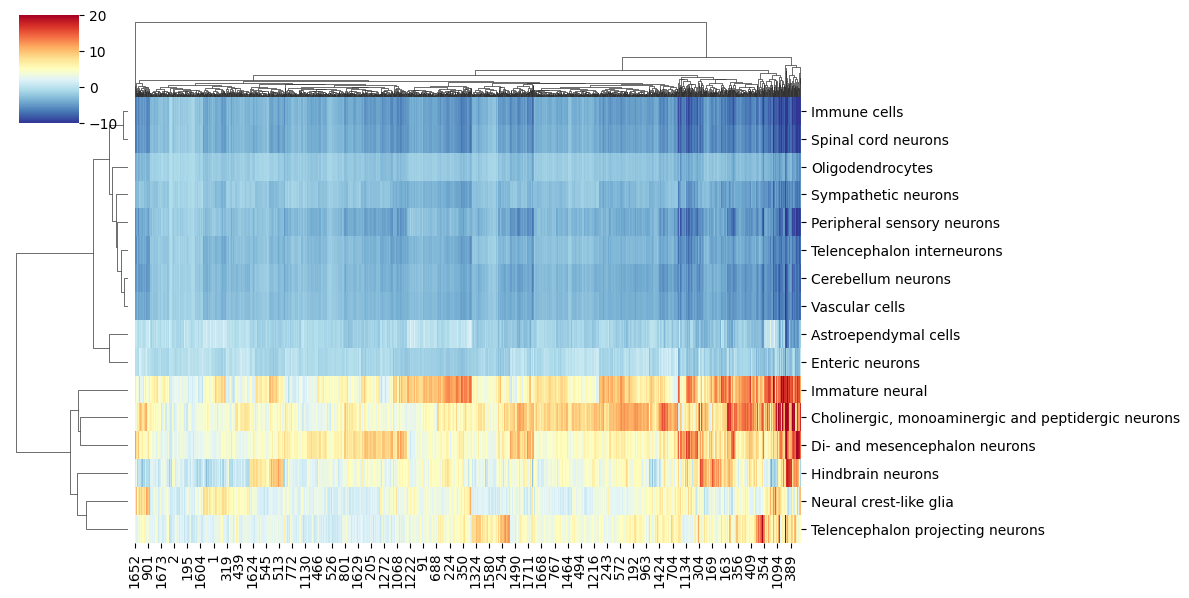

In [655]:
pi_kc_from_cluster = pd.read_csv('../results/from_cluster/toniCrop1_t05_LR3em5_pis.csv', index_col=0 )
pi_kc_from_cluster.columns = S.columns
#pi_kc_from_cluster = pd.DataFrame(np.ceil(pi_kc_from_cluster), columns = S.columns)
clustermap(pi_kc_from_cluster.T, figsize=(12,6),dendrogram_ratio=0.15, cmap='RdYlBu_r', vmin=-10, vmax=20)
plt.savefig('../results/figs/toniCrop1_pi_kc_gt5rna_t05_LR3em5_pis.pdf')
plt.show()

In [660]:
pi_kc_from_cluster.shape

(1728, 16)

/Users/acoudray/Desktop/tmp_samba/phd/gioele_project/2212_spatial-sc/spatial-sc/spatial-sc-env/lib/python3.7/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


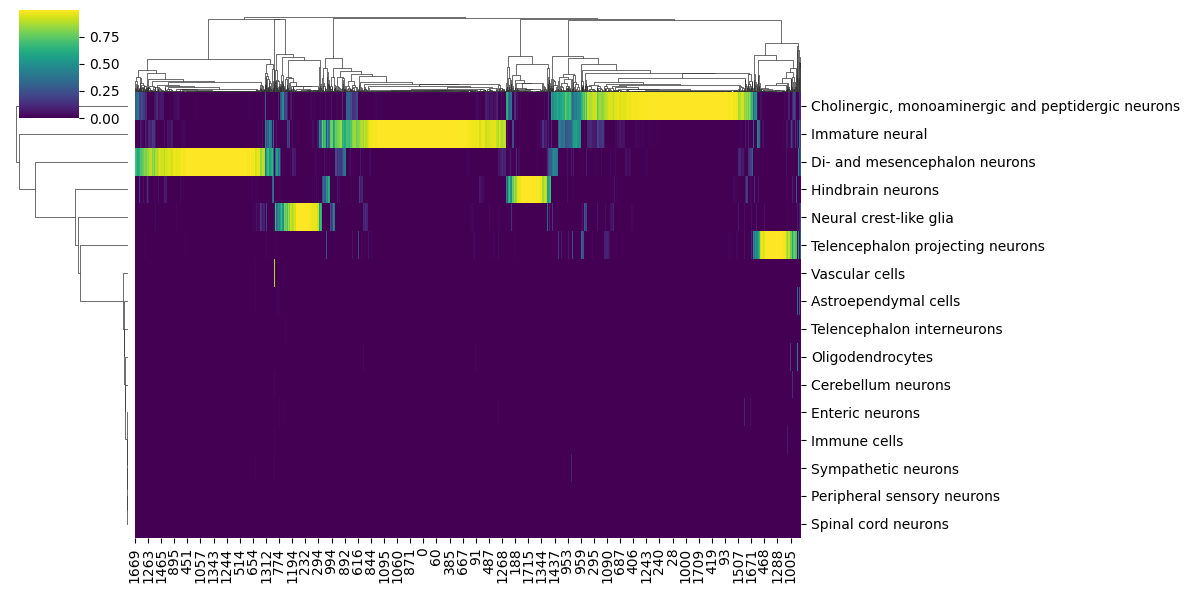

In [656]:
z_kc_from_cluster = pd.read_csv('../results/from_cluster/toniCrop1_t05_LR3em5_zs.csv', index_col=0 )
z_kc_from_cluster.columns = S.columns
g = clustermap(z_kc_from_cluster.T, figsize=(12,6),dendrogram_ratio=0.15, cmap='viridis')
plt.savefig('../results/figs/toniCrop1_gt5rna_t05_LR3em5_z_kc.pdf')
plt.show()

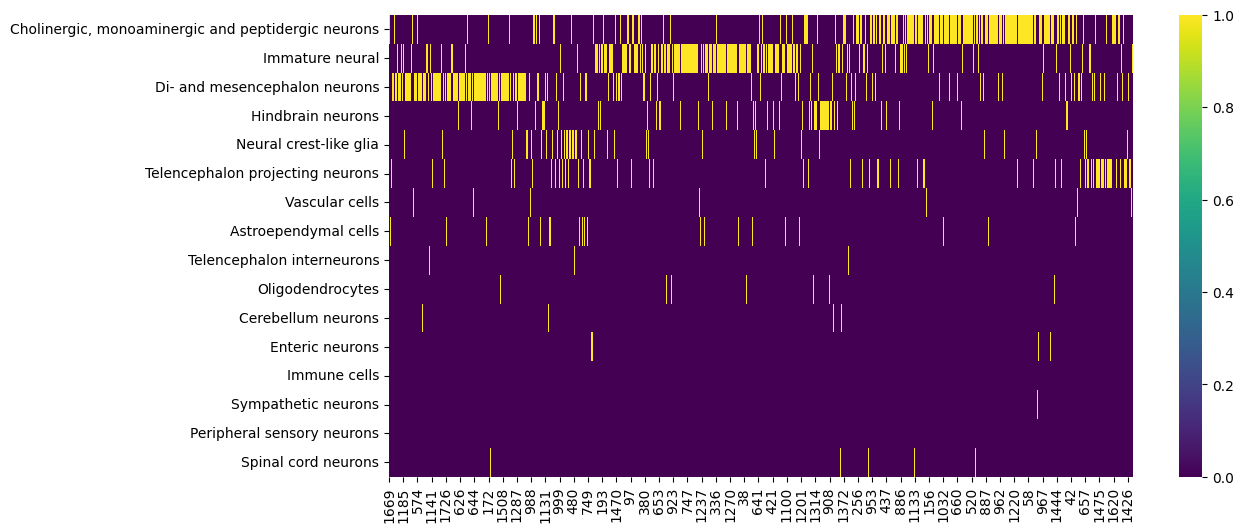

In [700]:
true_z_kc = pd.DataFrame(all_min_z, index=S.columns)
true_z_kc = true_z_kc.T.iloc[0:1728]
true_z_kc = true_z_kc.iloc[g.dendrogram_col.reordered_ind]
true_z_kc = true_z_kc.T.iloc[g.dendrogram_row.reordered_ind].T
plt.figure(figsize=(12,6))
heatmap(true_z_kc.T,cmap='viridis') # figsize=(12,6),dendrogram_ratio=0.1, 
plt.savefig('../results/figs/toniCrop1_gt5rna_t05_LR3em5_true_z.pdf')
plt.show()

In [590]:
loss_true_z_kc = pd.DataFrame(all_z_loss, index=S.columns)
loss_true_z_kc = loss_true_z_kc.T.iloc[0:1728]
loss_true_z_kc = loss_true_z_kc.iloc[g.dendrogram_col.reordered_ind]
loss_true_z_kc = loss_true_z_kc.T.iloc[g.dendrogram_row.reordered_ind].T


In [627]:
loss_true_z_kc_scale = scipy.stats.zscore(loss_true_z_kc.T).T
loss_true_z_kc_scale = np.sign(loss_true_z_kc_scale)*(loss_true_z_kc_scale**2)

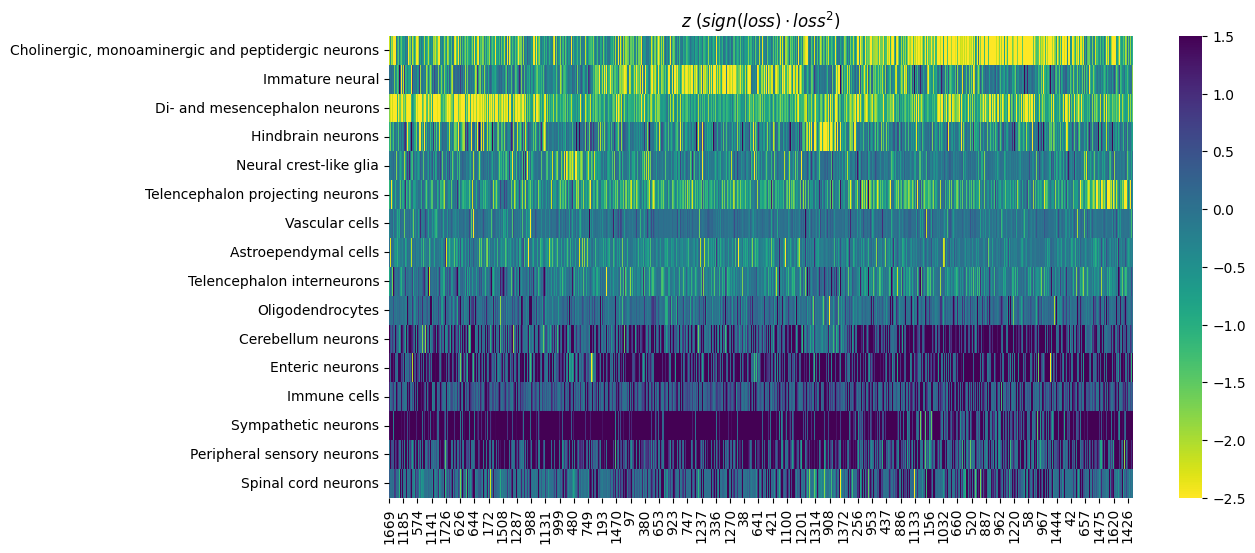

In [658]:
plt.figure(figsize=(12,6))
heatmap(loss_true_z_kc_scale.T,cmap='viridis_r', vmin=-2.5, vmax=1.5)
plt.title(r'$z\ (sign(loss) \cdot loss^2)$')
plt.savefig('../results/figs/toniCrop1_gt5rna_t05_LR3em5_true_z_lossSquare.pdf')
plt.show()

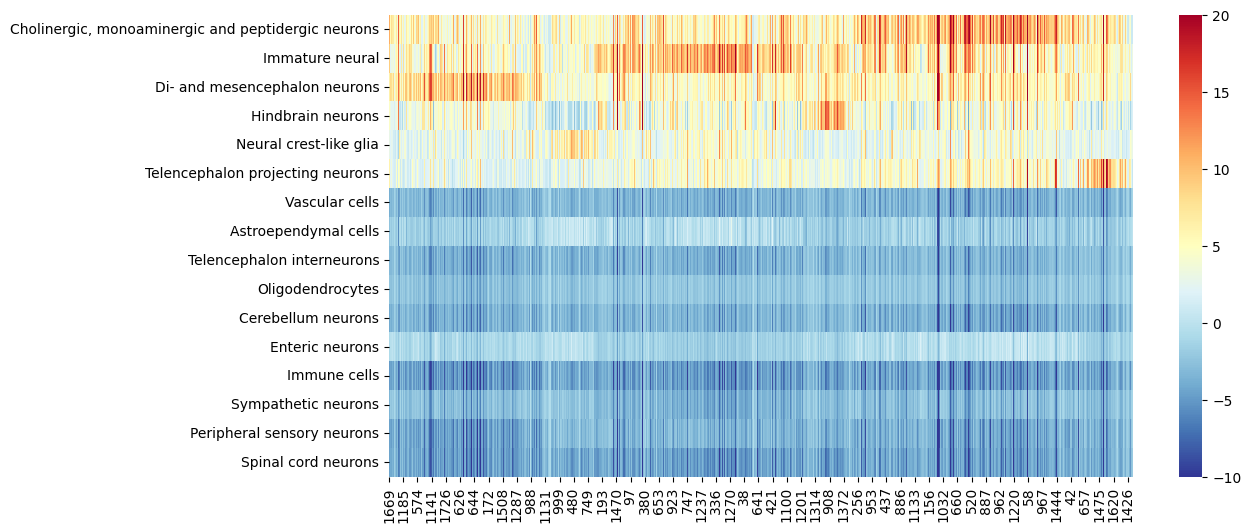

In [659]:
pi_kc_from_cluster = pi_kc_from_cluster.iloc[g.dendrogram_col.reordered_ind]
pi_kc_from_cluster = pi_kc_from_cluster.T.iloc[g.dendrogram_row.reordered_ind].T
plt.figure(figsize=(12,6))
heatmap(pi_kc_from_cluster.T, cmap='RdYlBu_r', vmin=-10, vmax=20)
plt.savefig('../results/figs/toniCrop1_gt5rna_t05_LR3em5_pi_kc_reorder.pdf')
plt.show()

In [675]:
import sklearn
import sklearn.metrics
from scipy.stats import pearsonr, spearmanr

In [694]:
z_kc_from_cluster_binary = (z_kc_from_cluster.T == z_kc_from_cluster.T.max()).astype(int).T

In [709]:
z_kc_from_cluster = z_kc_from_cluster.T.loc[S.columns].T
true_z_kc = true_z_kc.T.loc[S.columns].T

In [714]:
z_kc_from_cluster = z_kc_from_cluster.loc[true_z_kc.index]

In [724]:
pred_celltype = np.argmax(np.array(z_kc_from_cluster), axis=1)
true_celltype = np.argmax(np.array(true_z_kc), axis=1)

In [725]:
np.sum(pred_celltype == true_celltype)

1031

In [730]:
accuracy_k = np.zeros(16) ; abundance = np.zeros(16)
for k in range(15):
    sel_k = np.array(true_celltype == k)
    true_celltype_k = true_celltype[sel_k]
    pred_celltype_k = pred_celltype[sel_k]
    good_pred = np.sum(pred_celltype_k == true_celltype_k)
    if len(true_celltype_k) > 0:
        accuracy_k[k] = good_pred / len(true_celltype_k)
    else:
        accuracy_k[k] = None
    abundance[k] = len(true_celltype_k)

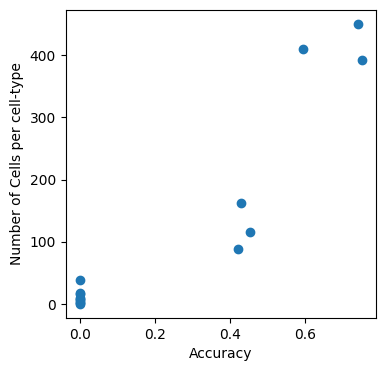

In [745]:
plt.figure(figsize=(4,4))
plt.plot(accuracy_k, abundance, 'o')
plt.xlabel('Accuracy') ; plt.ylabel('Number of Cells per cell-type')
plt.savefig('../results/accuracy_vs_celltype_prop.pdf', bbox_inches='tight')
plt.show()

In [748]:
30*50e3

1500000.0

In [679]:
spearmanr(np.array(z_kc_from_cluster).flatten(), np.array(true_z_kc).flatten())

SpearmanrResult(correlation=0.04593339579421432, pvalue=2.1495688239201228e-14)

In [508]:
accuracy_vector = pd.read_csv('../results/from_cluster/toniCrop1_t100lr4T01_2000epochs_accuracy.csv')

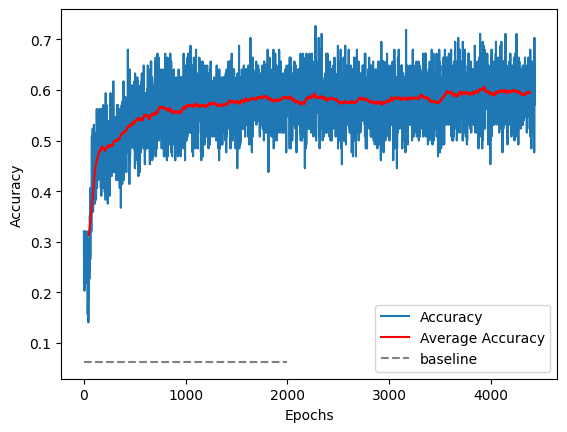

In [509]:
plt.plot(range(len(accuracy_vector)),accuracy_vector, label='Accuracy')
plt.plot(range(len(np.array(accuracy_vector.rolling(100).mean())[50:,0])),np.array(accuracy_vector.rolling(100).mean())[50:,0], c='red', label='Average Accuracy')
plt.xlabel('Epochs') ; plt.ylabel('Accuracy')
plt.hlines(1/16,xmin=0,xmax=2000, color='grey', linestyle='dashed', label='baseline')
plt.legend(loc='lower right')
plt.show()

In [531]:
acc1_v = pd.read_csv('../results/from_cluster/toniCrop1_2rcnn_tmp.csv', header=None)
acc2_v = pd.read_csv('../results/from_cluster/toniCrop1_3rcnn_tmp.csv', header=None)

In [532]:
rcnn3 = np.array(acc2_v.rolling(100).mean())[99:,0]
rcnn2 = np.array(acc1_v.rolling(100).mean())[99:,0]#[0:len(rcnn3)]

In [535]:
rcnn3 = rcnn3[1500:]

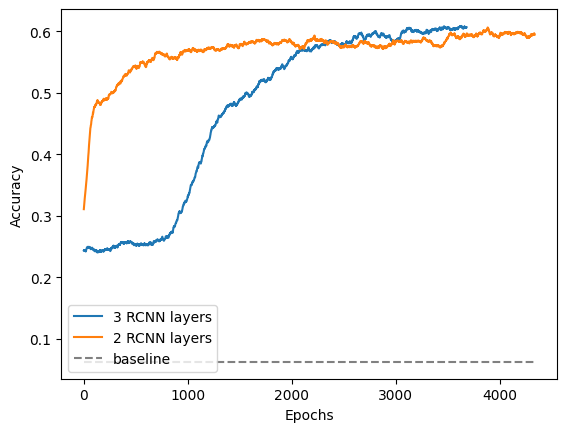

In [540]:
plt.plot(rcnn3, label='3 RCNN layers')
plt.plot(rcnn2, label='2 RCNN layers')
plt.xlabel('Epochs') ; plt.ylabel('Accuracy')
plt.hlines(1/16,xmin=0,xmax=max(len(rcnn2),len(rcnn3)), color='grey', linestyle='dashed', label='baseline')
plt.legend(loc='lower left')
plt.show()

In [542]:
(4500*128)/1500

384.0

In [513]:
rank_vector = pd.read_csv('../results/from_cluster/toniCrop1_t100lr4T01_2000epochs_ranks.csv', header = None)

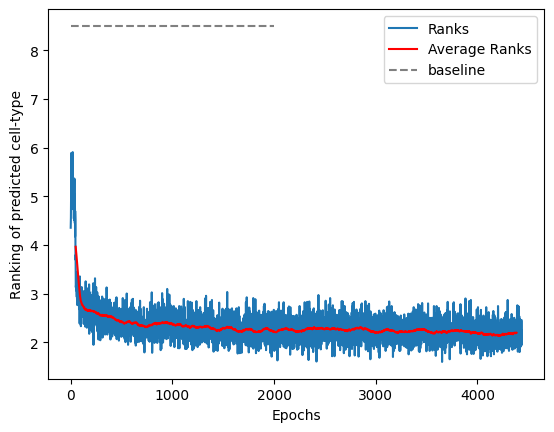

In [514]:
plt.plot(range(len(rank_vector)),rank_vector, label='Ranks')
plt.plot(range(len(np.array(rank_vector.rolling(100).mean())[50:,0])),np.array(rank_vector.rolling(100).mean())[50:,0], c='red', label='Average Ranks')
plt.hlines(8.5,xmin=0,xmax=2000, color='grey', linestyle='dashed', label='baseline')
plt.legend(loc="upper right")
plt.xlabel('Epochs') ; plt.ylabel('Ranking of predicted cell-type')
plt.show()

In [741]:
loss_vector = pd.read_csv('../results/from_cluster/toniCrop1_t05_LR3em5_2000epochs_loss.csv')

In [742]:
minloss_vector = pd.read_csv('../results/from_cluster/toniCrop1_t05_LR3em5_2000epochs_MaxLiMinLoss.csv')

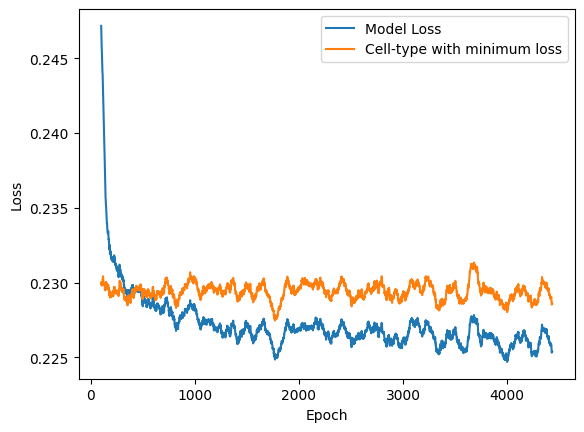

In [744]:
plt.plot(range(len(loss_vector.rolling(100).mean())),loss_vector.rolling(100).mean(), label='Model Loss')
plt.plot(range(len(minloss_vector.rolling(100).mean())),minloss_vector.rolling(100).mean(), label='Cell-type with minimum loss')
plt.legend(loc="upper right")
plt.xlabel('Epoch') ; plt.ylabel('Loss')
plt.savefig('../results/figs/toniCrop1_loss_vs_true_4k_epochs.pdf', bbox_inches='tight')
plt.show()

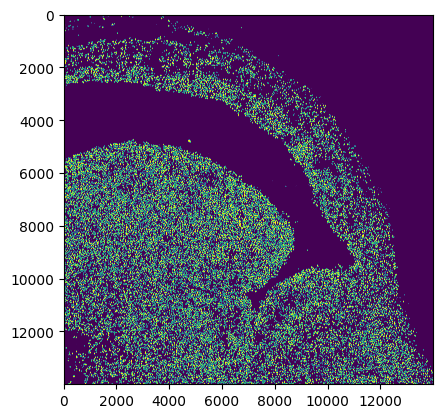

In [738]:
mask = seg.copy()
mask[mask > 0] = 1
plt.imshow(mask)
plt.savefig('../results/figs/toniCrop1_mask.pdf')